In [1]:
import math
import os
os.sys.path.append("../")
import re
from typing import Union
from itertools import combinations
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial, stats
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm 
import networkx as nx

import MSDiversity as msd
import graph
import utils

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

# Helper Functions

In [3]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [4]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [5]:
def calculate_interactions(dataframe):
    interactions = {}
    all_cell_types = set(dataframe.columns.get_level_values(0).unique().tolist() + dataframe.columns.get_level_values(1).unique().tolist())
    
    for cell_type in all_cell_types:
        # Find all columns where the cell type is present
        related_columns = (dataframe.columns.get_level_values(0) == cell_type) | (dataframe.columns.get_level_values(1) == cell_type)
        
        # Get the unique cell types interacting with the given cell type
        interacting_cell_types = set(dataframe.columns[related_columns].get_level_values(0).unique().tolist() + dataframe.columns[related_columns].get_level_values(1).unique().tolist())
        
        # Remove the cell type itself from the set of interacting cell types
        interacting_cell_types.discard(cell_type)
        
        # Store the number of unique interacting cell types
        interactions[cell_type] = len(interacting_cell_types)
    
    return interactions

# Read Data

In [6]:
adata = ad.read_h5ad('../../CellCharter/data/codex_mouse_spleen.h5ad')

In [7]:
adata.obsm['spatial'] = adata.obsm['spatial']/1000

In [8]:
adata

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors'
    obsm: 'blanks', 'spatial'

In [12]:
adata.uns['spatial']

{'BALBc-1': {},
 'BALBc-2': {},
 'BALBc-3': {},
 'MRL-4': {},
 'MRL-5': {},
 'MRL-6': {},
 'MRL-7': {},
 'MRL-8': {},
 'MRL-9': {}}

# Compute cell-type local neighbourhood entropy

In [40]:
df = adata.obs[['cell_type', 'sample', 'stage']].copy()
df.loc[:, 'spatial_x'] = adata.obsm['spatial'][:, 0]
df.loc[:, 'spatial_y'] = adata.obsm['spatial'][:, 1]
df

cell_type   sample     stage  spatial_x  spatial_y
0        CD11c(+) B cells  BALBc-1     BALBc    189.128    833.216
1        CD11c(+) B cells  BALBc-1     BALBc    442.740    866.116
2        CD11c(+) B cells  BALBc-1     BALBc    444.056    144.196
3        CD11c(+) B cells  BALBc-1     BALBc    191.760    961.620
4        CD11c(+) B cells  BALBc-1     BALBc    697.856   1516.032
...                   ...      ...       ...        ...        ...
79343-4    CD4(+)MHCII(+)    MRL-9  late MRL   1181.580    892.060
79344-4    CD4(+)MHCII(+)    MRL-9  late MRL     17.108    449.132
79345-4    CD4(+)MHCII(+)    MRL-9  late MRL   1183.836    891.496
79346-4    CD4(+)MHCII(+)    MRL-9  late MRL   1445.156   1481.252
79347-4    CD4(+)MHCII(+)    MRL-9  late MRL   1193.800   1126.496

[707474 rows x 5 columns]

In [41]:
cluster_key = 'cell_type'

In [42]:
n_neighbors=20
all_neighbourhoods = []
original_indices = []

for each_region in tqdm(pd.unique(df['sample'])):
    df_sub = df.loc[df['sample'] == each_region,:].copy()
    current_indices = df_sub.index.tolist()
    original_indices.extend(current_indices)
    locations = df_sub[['spatial_x', 'spatial_y']].values
    spatial_knn_indices = graph.get_spatial_knn_indices(locations=locations, n_neighbors=n_neighbors, method='kd_tree') 

    feature_labels = df_sub[cluster_key].values
    cell_nbhds = utils.get_global_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels, all_labels = df[cluster_key].unique())
    all_neighbourhoods.extend(cell_nbhds)
    
paired = list(zip(original_indices, all_neighbourhoods))
paired.sort()
all_neighbourhoods_sorted = np.array([nbhd for _, nbhd in paired])
original_indices_sorted = np.array([idx for idx, _ in paired])    

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.49s/it]


In [43]:
neighbourhoods_diversity = []
for nbhd in all_neighbourhoods_sorted:
    nbhd = nbhd[nbhd!=0]
    neighbourhoods_diversity.append(msd.calculate_shannon_entropy(nbhd))

In [44]:
# Sanity Check
print(np.where(original_indices_sorted =='0'))
print(neighbourhoods_diversity[np.where(original_indices_sorted =='0')[0][0]])

(array([0]),)
1.6788979029874789


In [45]:
df['diversity'] = 0.0
df.loc[original_indices_sorted, 'diversity'] = neighbourhoods_diversity
df

cell_type   sample     stage  spatial_x  spatial_y  diversity
0        CD11c(+) B cells  BALBc-1     BALBc    189.128    833.216   1.678898
1        CD11c(+) B cells  BALBc-1     BALBc    442.740    866.116   2.157717
2        CD11c(+) B cells  BALBc-1     BALBc    444.056    144.196   2.163865
3        CD11c(+) B cells  BALBc-1     BALBc    191.760    961.620   1.021928
4        CD11c(+) B cells  BALBc-1     BALBc    697.856   1516.032   2.321127
...                   ...      ...       ...        ...        ...        ...
79343-4    CD4(+)MHCII(+)    MRL-9  late MRL   1181.580    892.060   2.501609
79344-4    CD4(+)MHCII(+)    MRL-9  late MRL     17.108    449.132   2.363865
79345-4    CD4(+)MHCII(+)    MRL-9  late MRL   1183.836    891.496   2.723220
79346-4    CD4(+)MHCII(+)    MRL-9  late MRL   1445.156   1481.252   2.114980
79347-4    CD4(+)MHCII(+)    MRL-9  late MRL   1193.800   1126.496   2.095462

[707474 rows x 6 columns]

In [46]:
df_diversity = df.groupby(['sample',cluster_key])['diversity'].mean().reset_index()
df_diversity['stage'] = ' '
df_diversity.loc[df_diversity['sample'].str.contains('BALBc'), 'stage'] = 'BALBc'
df_diversity.loc[df_diversity['sample'].str.contains('MRL'), 'stage'] = 'MRL'
df_diversity

sample                 cell_type  diversity  stage
0    BALBc-1        B220(+) DN T cells   1.852577  BALBc
1    BALBc-1                   B cells   1.384905  BALBc
2    BALBc-1  CD3(+) other markers (-)   2.377513  BALBc
3    BALBc-1            CD4(+) T cells   1.522594  BALBc
4    BALBc-1           CD4(+)CD8(-)cDC   2.251302  BALBc
..       ...                       ...        ...    ...
238    MRL-9              granulocytes   2.382081    MRL
239    MRL-9        marginal zone mphs   2.180377    MRL
240    MRL-9            megakaryocytes   2.617111    MRL
241    MRL-9                      noid   2.191987    MRL
242    MRL-9              plasma cells   2.421297    MRL

[243 rows x 4 columns]

In [48]:
anova_p_values = []
selected_cell_types = sorted(df_diversity[cluster_key].unique())
for cell_name in selected_cell_types:
    cell_data = df_diversity[df_diversity[cluster_key] == cell_name]
    stages = cell_data['stage'].unique()
    groups = [cell_data['diversity'][cell_data['stage'] == stage] for stage in stages]
    
    # Perform ANOVA test
    f_statistic, p_value = stats.ttest_ind(groups[0].astype(np.float32), groups[1].astype(np.float32), equal_var=False)
    anova_p_values.append(p_value)
    
anova_pvals_corrected = stats.false_discovery_control(anova_p_values, method='bh')
for i, cell_name in enumerate(selected_cell_types): 
    print(f"Cell type {cell_name} before BH is {anova_p_values[i]}")
    print(f"Cell type {cell_name} after BH is {anova_pvals_corrected[i]}")
    print('*'*42)

Cell type B cells before BH is 0.19782389812726278
Cell type B cells after BH is 0.3338278280897559
******************************************
Cell type B220(+) DN T cells before BH is 0.42626520157892844
Cell type B220(+) DN T cells after BH is 0.5231436564832304
******************************************
Cell type CD106(+)CD16/32(+)CD31(+) stroma before BH is 0.08482040737432928
Cell type CD106(+)CD16/32(+)CD31(+) stroma after BH is 0.2081955453733537
******************************************
Cell type CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma before BH is 0.6852115717775478
Cell type CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma after BH is 0.7708630182497412
******************************************
Cell type CD106(+)CD16/32(-)Ly6C(+)CD31(+) before BH is 0.2735333014638994
Cell type CD106(+)CD16/32(-)Ly6C(+)CD31(+) after BH is 0.36926995697626425
******************************************
Cell type CD106(-)CD16/32(+)Ly6C(+)CD31(-) before BH is 0.02153525304152134
Cell type CD106(-)CD16/3

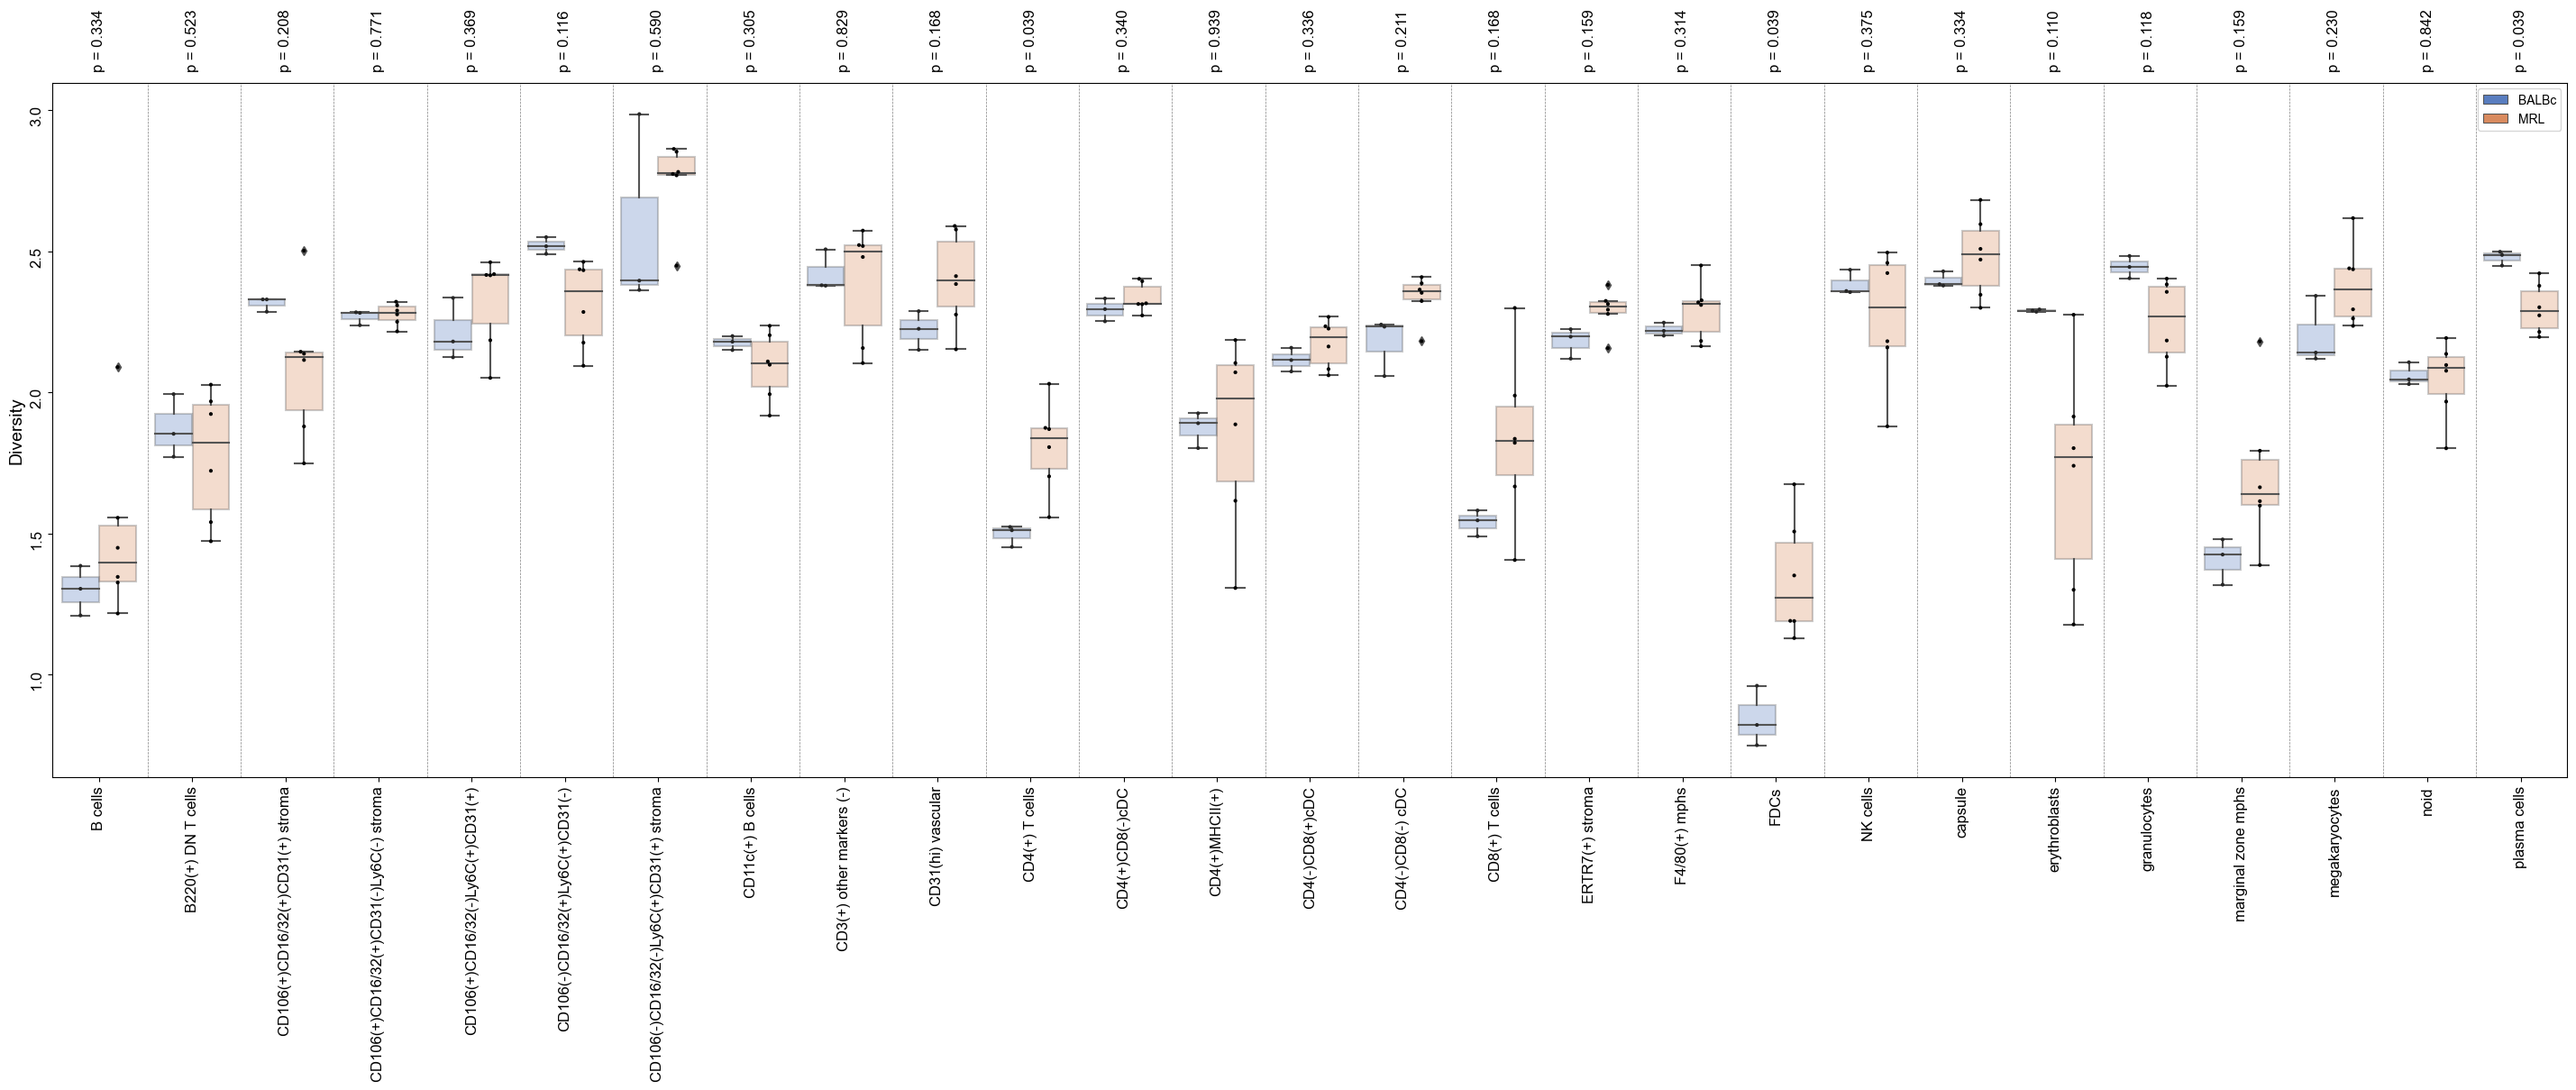

In [49]:
save_path = 'cell_diveristy_'+cluster_key.split(' ')[0]+'.svg'

# Visualization
fig, ax = plt.subplots(figsize=(36,10))
sns.boxplot(data=df_diversity, x=cluster_key, y='diversity', hue='stage', palette='muted', boxprops=dict(alpha=.3),order=selected_cell_types)
sns.swarmplot(data=df_diversity, x=cluster_key, y='diversity', hue='stage', dodge=True, size=3.0, palette='dark:black',order=selected_cell_types)

yrange = ax.get_ylim()[1] + 0.05
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {anova_pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=90)
    
for i in range(len(df_diversity[cluster_key].unique()) - 1):
    ax.axvline(i + 0.52, color='grey', linestyle='--', linewidth=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc=1)

ax.set_ylabel("Diversity", fontsize=14)
ax.set_xlabel('')
plt.xticks(fontsize=12, rotation=90)  
plt.yticks(fontsize=12, rotation=90) 

fig.savefig('../figures/mice/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/mice/'+save_path)
plt.show()
plt.close(fig)

# Heatmap & Hot/Cold Spots Illustration

In [26]:
test_sample = 'MRL-8'
scale = 64.0

In [27]:
patches_coordinates = msd.generate_patches(adata,'sample',test_sample,scaling_factor=scale, spatial_key='spatial')

In [28]:
len(patches_coordinates)

4096

In [29]:
adata_filtered = adata[adata.obs['sample']==test_sample]
spatial_value = adata_filtered.obsm['spatial']

0.098 per cent patches are empty


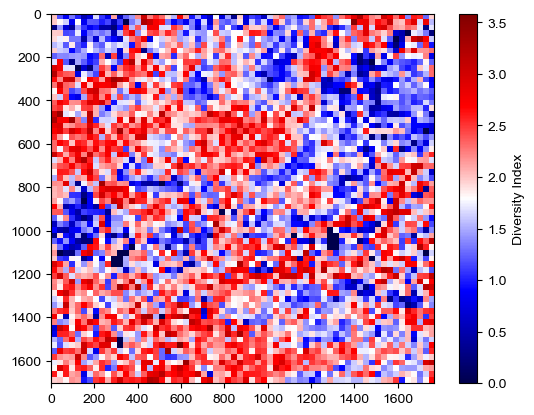

In [30]:
patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=adata, 
                                                            library_key='sample', 
                                                            library_id=test_sample, 
                                                            spatial_key='spatial', 
                                                            patches=patches_coordinates, 
                                                            cluster_key='cell_type', 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=adata,
                                          library_key='sample', 
                                          library_id=test_sample,
                                          spatial_key='spatial',
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=False,
                                          plot=True,
                                          return_fig=True)

In [68]:
save_path = test_sample + '_heatmap.svg'
heatmap_fig.savefig('../figures/mice/'+save_path)
plt.close(heatmap_fig)

In [31]:
print(msd.global_spatial_stats(grid,tissue_only=False))

(0.3794937224532291, 0.001)


In [32]:
hotspots, coldspots = msd.local_spatial_stats(grid,p_value=0.01,tissue_only=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)

331
423


In [33]:
combined_spots = (hotspots * 1) + (coldspots * -1) #+ (doughnuts * 0.5) + (diamonds * -0.5)
seismic = plt.cm.seismic
colors = [seismic(0), "lightblue", "white", "salmon", seismic(0.999)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

In [34]:
from scipy.ndimage import center_of_mass

In [35]:
Hot = True

1768.1399999999999 1704.784


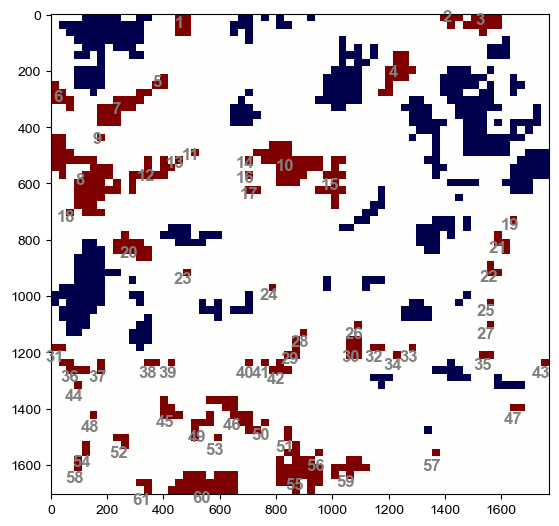

In [36]:
if Hot:
    labelled, num_islands = msd.label_islands(hotspots, rook=True)
else:
    labelled, num_islands = msd.label_islands(coldspots, rook=True)
    
min_x, min_y = spatial_value.min(axis=0)[0], spatial_value.min(axis=0)[1]
max_x, max_y = spatial_value.max(axis=0)[0], spatial_value.max(axis=0)[1]
width = max_x - min_x
height = max_y - min_y
print(width, height)
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with diversity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Calculate centroids of islands and label them
for label in range(1, num_islands + 1):
    positions = np.where(labelled == label)
    if positions[0].size > 0:
        centroid = center_of_mass(labelled == label)
        ax.text(centroid[1]*width/scale, 
                centroid[0]*width/scale, 
                str(label), 
                fontsize=12,
                fontweight='semibold',
                color='grey',
                ha='center', 
                va='center')
       
# Plot the heatmap
ax.imshow(grid, cmap=cmap, interpolation='none', vmin=-1, vmax=1)

# save_path = test_sample + '_spot.svg'
# spot_fig.savefig('../figures/mice/'+save_path, dpi=300)

In [22]:
def aggregate_spot_compositions(spots, labelled, compositions):
    """
    Aggregate compositions of spots that belong to the same island.

    Parameters:
    - spots: Boolean array indicating whether each patch is a spot.
    - labelled: Array of the same shape as 'spots', where each component (island) has a unique label.
    - compositions: List of pd.Series, each representing the composition of a spot, or None for spots without compositions.

    Returns:
    - pd.DataFrame: DataFrame where each row corresponds to an island's aggregated composition.
    """
    # Initialize a DataFrame to store the aggregated data
    aggregated_df = pd.DataFrame()

    # Iterate over each unique label (island)
    for label in range(1, np.max(labelled) + 1):
        # Find indices where the current label is present
        indices = (labelled == label) & spots
        
        # Sum compositions for the current island
        island_composition = pd.Series(dtype='float')
        for index in np.nonzero(indices)[0]:
            current_composition = compositions[index]
            if current_composition is None:
                current_composition = pd.Series(0, index=island_composition.index)
            island_composition = island_composition.add(current_composition, fill_value=0)
        
        # Append the summed Series to the DataFrame
        aggregated_df[f'Island_{label}'] = island_composition

    return aggregated_df.T


In [37]:
if Hot:
    filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
    filtered_patches_comp = [patch for patch, is_hotspot in zip(patches_comp, hotspots.flatten()) if is_hotspot]
    island_comp = aggregate_spot_compositions(hotspots, labelled, filtered_patches_comp)
else:
    filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
    filtered_patches_comp = [patch for patch, is_coldspot in zip(patches_comp, coldspots.flatten()) if is_coldspot]
    island_comp = aggregate_spot_compositions(coldspots, labelled, filtered_patches_comp)

In [38]:
island_comp

cell_type  CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  CD3(+) other markers (-)  \
Island_1                                      26.0                       4.0   
Island_2                                      23.0                       NaN   
Island_3                                      51.0                       2.0   
Island_4                                      28.0                       NaN   
Island_5                                      12.0                       NaN   
...                                            ...                       ...   
Island_57                                      NaN                       NaN   
Island_58                                      NaN                       1.0   
Island_59                                     10.0                       5.0   
Island_60                                     46.0                       NaN   
Island_61                                      4.0                       NaN   

cell_type  CD31(hi) vascular  CD4(+) T cells  CD4(+)CD8(-)cDC  CD4(+)MHCII(+)  \
Island_1                 4.0             8.0             22.0             4.0   
Island_2                 4.0             NaN             16.0             4.0   
Island_3                 9.0             4.0             48.0             9.0   
Island_4                 2.0            69.0             30.0             NaN   
Island_5                 4.0            14.0              7.0             NaN   
...                      ...             ...              ...             ...   
Island_57                1.0             1.0              NaN             NaN   
Island_58                NaN             5.0              NaN             NaN   
Island_59                NaN            16.0              NaN             NaN   
Island_60                NaN             NaN              NaN             NaN   
Island_61                NaN             NaN              NaN             NaN   

cell_type  CD4(-)CD8(-) cDC  CD8(+) T cells  F4/80(+) mphs  NK cells  \
Island_1                2.0             4.0            2.0       2.0   
Island_2                1.0             1.0            NaN       NaN   
Island_3                5.0             6.0            1.0       1.0   
Island_4                4.0            44.0            8.0       NaN   
Island_5                NaN             4.0            NaN       NaN   
...                     ...             ...            ...       ...   
Island_57               NaN             4.0            1.0       NaN   
Island_58               NaN             2.0            NaN       1.0   
Island_59               NaN             4.0            4.0       2.0   
Island_60              16.0             9.0           12.0       NaN   
Island_61               4.0             1.0            NaN       NaN   

cell_type  erythroblasts  granulocytes  plasma cells  
Island_1            24.0           4.0          14.0  
Island_2            10.0           NaN          19.0  
Island_3            34.0           2.0          29.0  
Island_4            10.0           2.0          20.0  
Island_5             3.0           NaN           5.0  
...                  ...           ...           ...  
Island_57            2.0           1.0           NaN  
Island_58            7.0           4.0           NaN  
Island_59           38.0          17.0           2.0  
Island_60           52.0          34.0          14.0  
Island_61            6.0           4.0           2.0  

[61 rows x 13 columns]

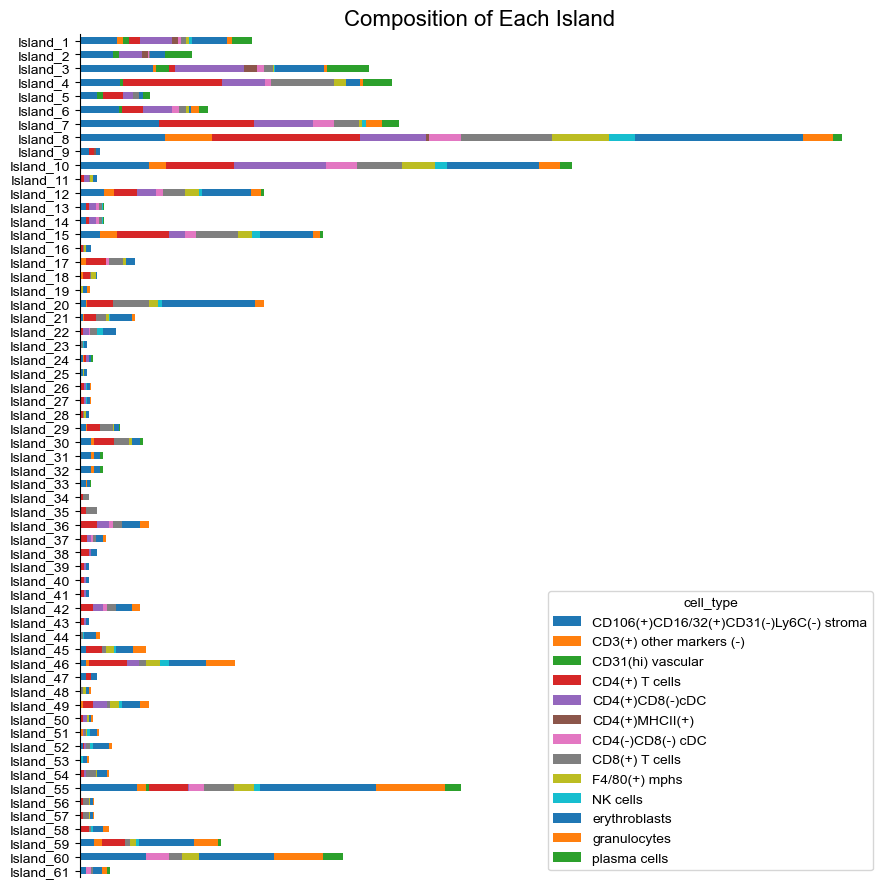

In [39]:
ax = island_comp.plot(kind='barh', stacked=True, figsize=(9,9))

# Set plot title, axis labels, and legend
plt.title('Composition of Each Island', fontsize=16)
plt.xlabel('Islands', fontsize=12)
plt.ylabel('')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.legend(title='Component', ncol=2, fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.invert_yaxis()

# Show the plot with a clean layout
plt.tight_layout()
# if Hot:
#     plt.savefig('../figures/mice/'+test_sample+'_hot_island_composition.png')
#     plt.savefig('../figures/mice/'+test_sample+'_hot_island_composition.svg')
# else:
#     plt.savefig('../figures/mice/'+test_sample+'_cold_island_composition.png')
#     plt.savefig('../figures/mice/'+test_sample+'_cold_island_composition.svg')
plt.show()

In [21]:
msd.combination_freq(filtered_patches_comp, n=2, top=None)['ERTR7(+) stroma']

erythroblasts         0.226586
plasma cells          0.132931
F4/80(+) mphs         0.120846
granulocytes          0.111782
noid                  0.084592
NK cells              0.057402
megakaryocytes        0.021148
marginal zone mphs    0.015106
capsule               0.003021
dtype: float64

In [18]:
from matplotlib.patches import Rectangle

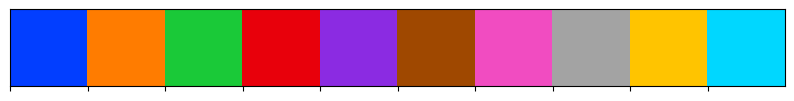

In [22]:
cell_types_visual = ['F4/80(+) mphs', 'ERTR7(+) stroma']
marker_dict = {
    cell_types_visual[0]: 'X',
    cell_types_visual[1]: '^'
}
custom_colors = sns.color_palette("bright")
sns.palplot(custom_colors)

color_dict = {
    cell_types_visual[0]: custom_colors[-1],
    cell_types_visual[1]: custom_colors[-5]
}

1768.1399999999999
1704.784


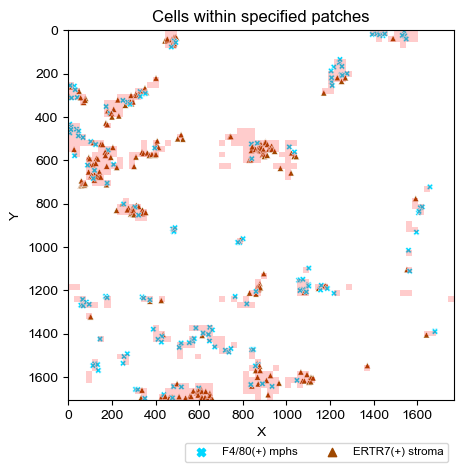

In [23]:
co_loc_fig = msd.plot_cells_patches(spatial_data=adata, 
                                    library_key='sample',
                                    library_id=test_sample,
                                    spatial_key='spatial',
                                    cluster_key='cell_type',
                                    patches=filtered_patches_coordinates,
                                    selected_cell_types=cell_types_visual,
                                    marker_styles=marker_dict,
                                    color_palette=color_dict,
                                    patch_alpha=0.2)
# save_path = test_sample + '_coloc.svg'
# co_loc_fig.savefig('../figures/mice/'+save_path, dpi=300)
# save_path = save_path.replace('.svg','.png')
# co_loc_fig.savefig('../figures/mice/'+save_path, dpi=300)

In [20]:
# Extracting cell_type, stage, sample
df_obs = adata.obs[['cell_type', 'stage', 'sample']].reset_index()

# Extracting spatial coordinates
df_spatial = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'])

# Concatenating the data frames
df_final = pd.concat([df_obs, df_spatial], axis=1)

In [ ]:
# Create the scatter plot
sns.scatterplot(data=df_final[(df_final['sample']=='MRL-8')],
                hue='cell_type',
                s=1,
                x='x_coord', y='y_coord')

# Adding labels and title for clarity
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial distribution of CD8(+) T cells in sample MRL-8')

# Show the plot
plt.show()

# Calculate Multi-Scale Homogeneity Index

In [9]:
# Define the sequence of scales
scales = [2., 4., 8., 16., 24., 32., 48., 64., 72.] # For Morna's I
scales = [1., 2., 4., 8., 16., 32., 64.] # For Diversity

In [10]:
# Define the library_ids
library_ids = ['BALBc', 'early MRL', 'intermediate MRL', 'late MRL']
library_ids = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']
library_ids = ['BALBc-1' ]

Processing region: BALBc-1 at scale 1.0
0.000 per cent patches are empty
BALBc-1 at scale 1.0 has 0 patches with zero diveristy
BALBc-1 at scale 1.0 diversity is 2.8224049147168166
Processing region: BALBc-1 at scale 2.0
0.000 per cent patches are empty
BALBc-1 at scale 2.0 has 0 patches with zero diveristy
BALBc-1 at scale 2.0 diversity is 2.8096339612313344
Processing region: BALBc-1 at scale 4.0
0.000 per cent patches are empty
BALBc-1 at scale 4.0 has 0 patches with zero diveristy
BALBc-1 at scale 4.0 diversity is 2.6784053488305974
Processing region: BALBc-1 at scale 8.0
0.000 per cent patches are empty
BALBc-1 at scale 8.0 has 0 patches with zero diveristy
BALBc-1 at scale 8.0 diversity is 2.4799987919407114
Processing region: BALBc-1 at scale 16.0
1.172 per cent patches are empty
BALBc-1 at scale 16.0 has 0 patches with zero diveristy
BALBc-1 at scale 16.0 diversity is 2.286806849622593
Processing region: BALBc-1 at scale 32.0
1.855 per cent patches are empty
BALBc-1 at scale 32

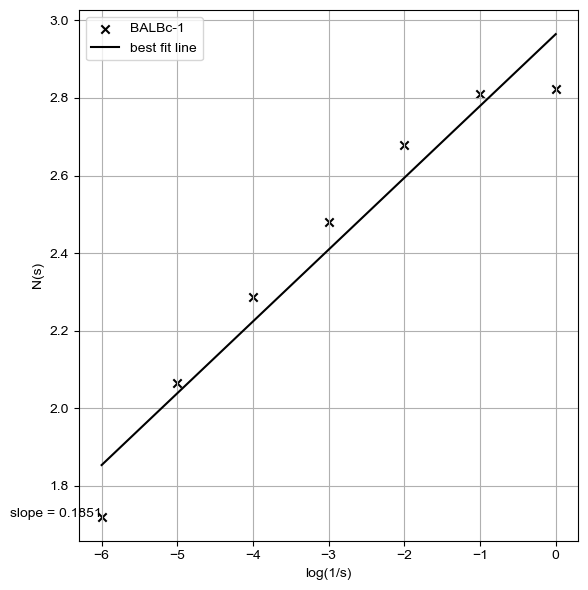

In [11]:
df_entropy, df_slopes = msd.multiscale_diversity(spatial_data=adata,
                                                 scales=scales,
                                                 library_key='sample',
                                                 library_ids=library_ids,
                                                 spatial_key='spatial',
                                                 cluster_key='cell_type',
                                                 mode='D',
                                                 random_patch=False,
                                                 plotfigs=True,
                                                 savefigs=True,
                                                 patch_kwargs={'random_seed': None, 'min_points':2},
                                                 other_kwargs={'metric': 'Shannon Diversity'})

In [21]:
df_results = pd.concat([df_entropy.transpose(), df_slopes.transpose()], axis=1)
df_results=df_results.rename(columns={0.0: 'Slope'})
df_results['Condition'] = ' '
df_results['Sample_id'] = df_results.index
df_results.loc[df_results.index.str.contains('BALBc'), 'Condition'] = 'BALBc'
df_results.loc[df_results.index.str.contains('MRL'), 'Condition'] = 'MRL'
# for col in df_results.columns[:-2]:  # Exclude 'Slope' and 'Condition'
#     df_results[f'Avg_{col}'] = df_results.groupby('Condition')[col].transform('mean')
df_results

1.0       2.0       4.0       8.0      16.0      32.0      64.0  \
BALBc-1  2.822405  2.809634  2.678405  2.479999  2.286807  2.066045  1.721111   
BALBc-2  2.874238  2.838216  2.685395  2.526869  2.305148  2.077747  1.732378   
BALBc-3  2.811676  2.741065   2.63052  2.463874  2.255114  2.004529  1.659183   
MRL-4    3.126137  3.083159  2.986427   2.78146   2.55512  2.269588  1.792999   
MRL-5    3.258509  3.059884  2.811016  2.543652  2.333971  2.038872  1.585257   
MRL-6     3.34431  3.086245   2.95716  2.744414  2.548276  2.283961   1.83675   
MRL-7    3.128434   2.99235  2.730446  2.491934  2.286958  2.026418  1.618829   
MRL-8    3.465678  3.292377  3.090165  2.866161  2.631289  2.332991  1.871333   
MRL-9    3.371959  3.200401  3.067467  2.848272  2.669482  2.417582  1.985302   

            Slope Condition Sample_id  
BALBc-1  0.185095     BALBc   BALBc-1  
BALBc-2  0.190242     BALBc   BALBc-2  
BALBc-3  0.189498     BALBc   BALBc-3  
MRL-4    0.216352       MRL     MRL-4  
MRL-5    0.269244       MRL     MRL-5  
MRL-6    0.233433       MRL     MRL-6  
MRL-7    0.246577       MRL     MRL-7  
MRL-8    0.255739       MRL     MRL-8  
MRL-9    0.218700       MRL     MRL-9

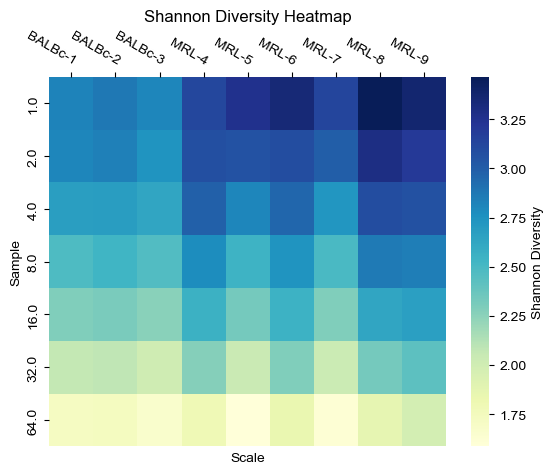

In [75]:
#scales.append('Slope')
numerical_data = df_results[scales].astype(float).T

# Create the heatmap
plt.figure()
ax = sns.heatmap(numerical_data, annot=False, fmt=".3f", cmap='YlGnBu', cbar_kws={'label': 'Shannon Diversity'})
ax.xaxis.tick_top() 
plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
plt.title('Shannon Diversity Heatmap')
plt.xlabel('Scale')
plt.ylabel('Sample')
plt.show()

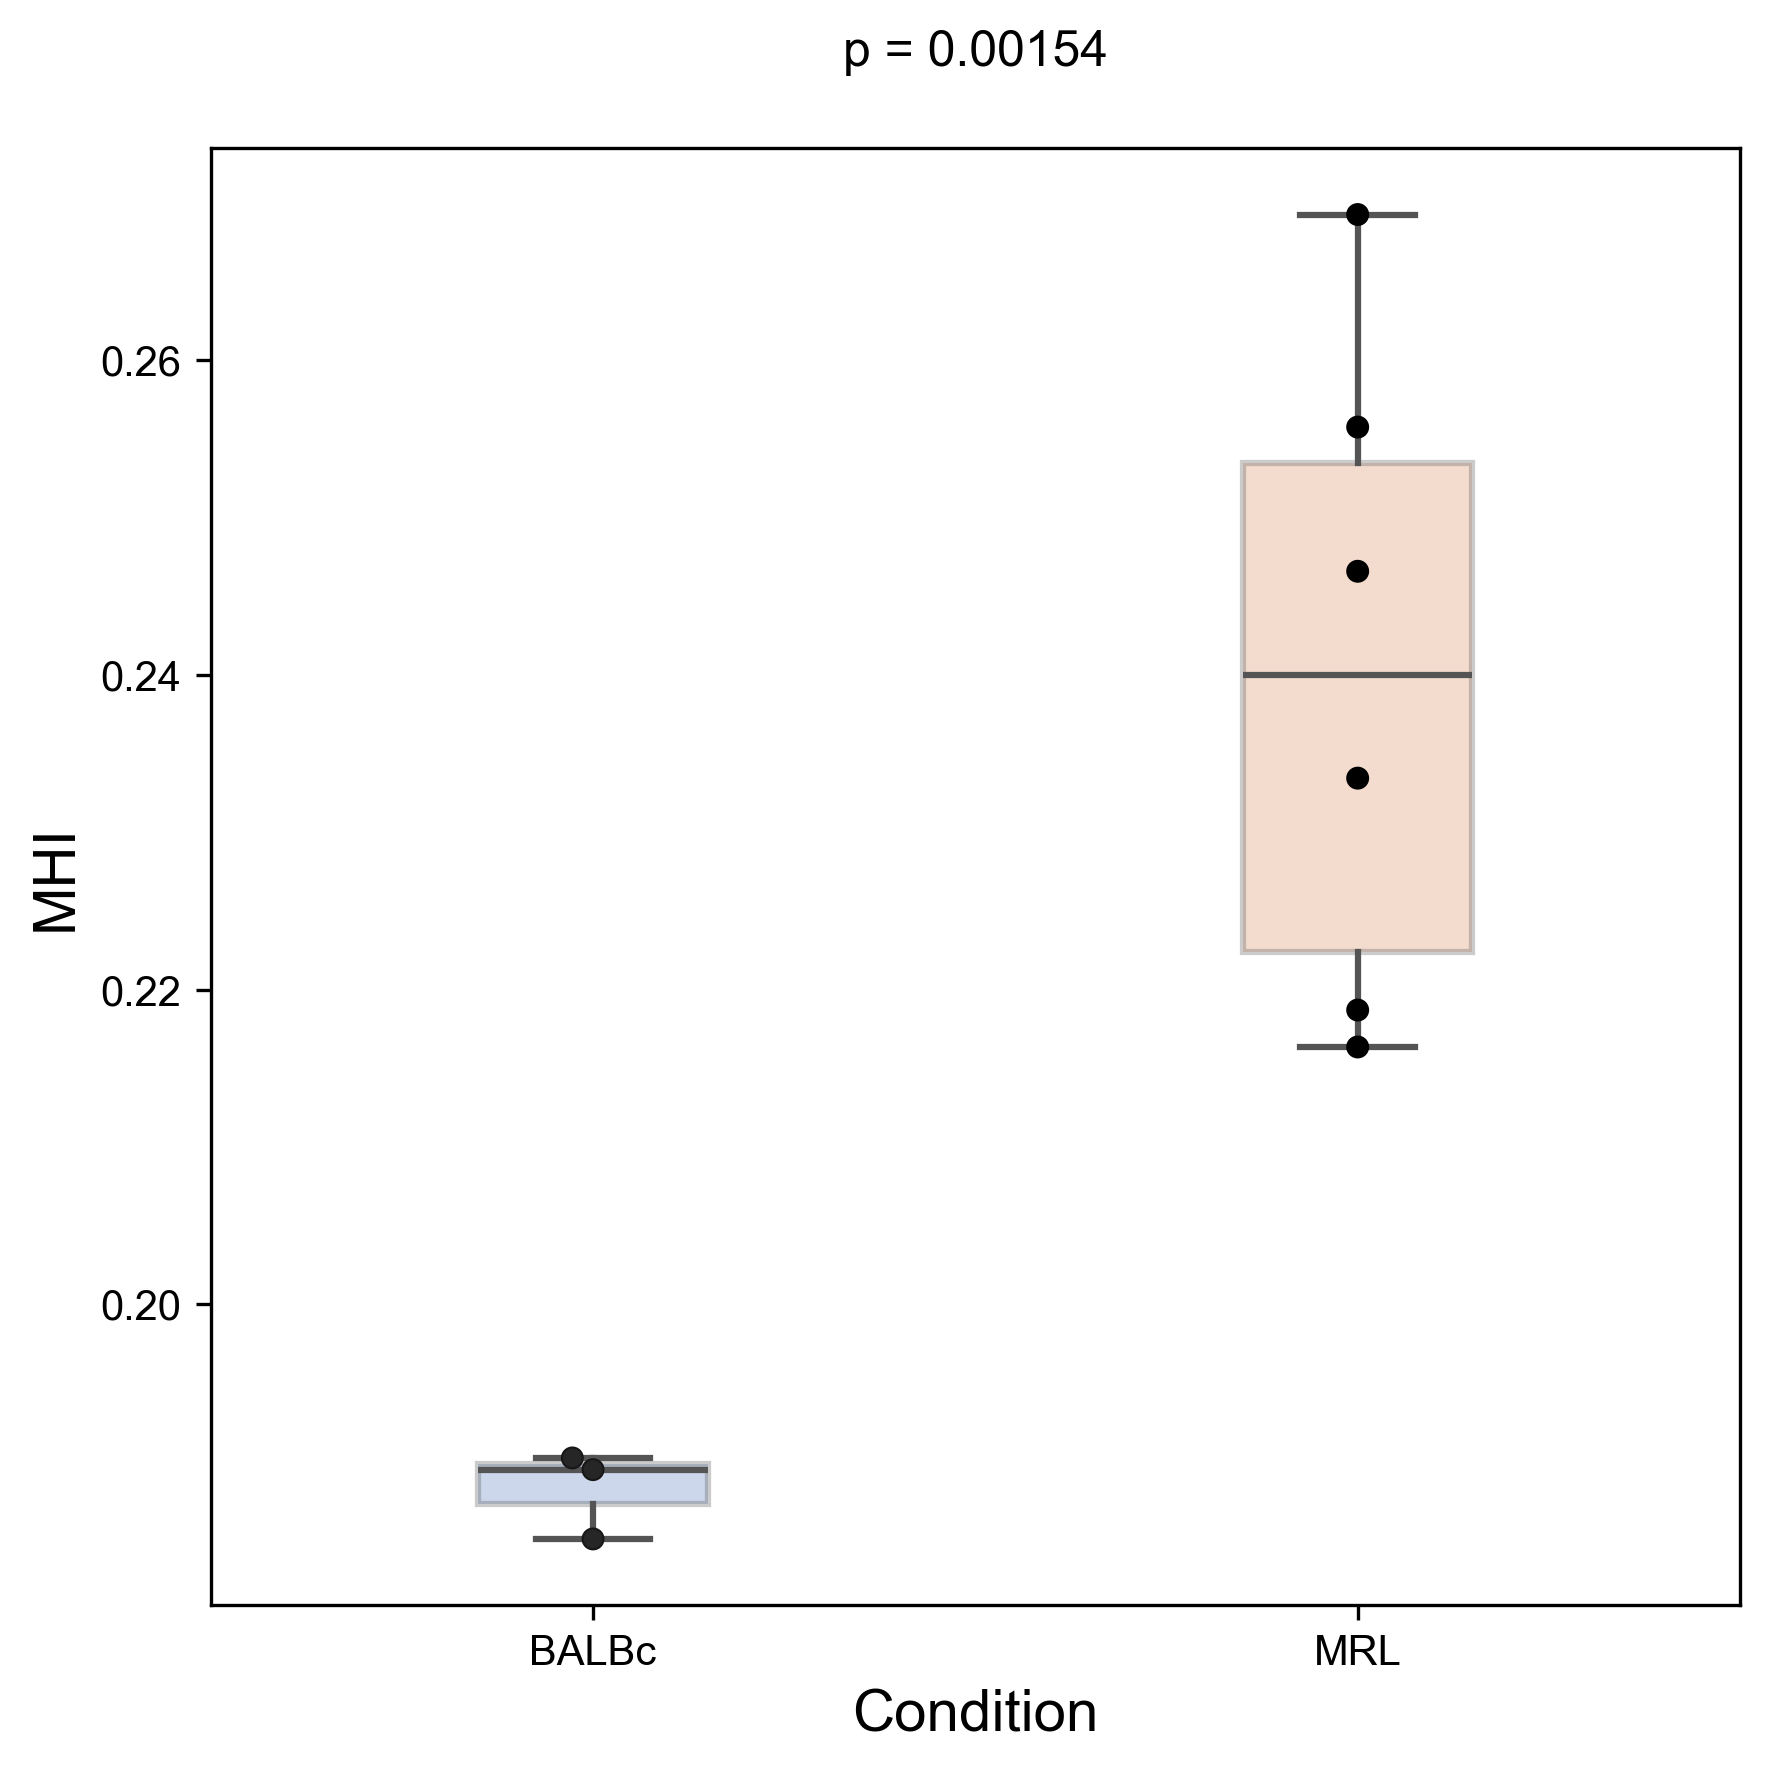

In [17]:
# Set a style that's commonly used for publications
fig, ax = plt.subplots(figsize=(6, 6),dpi=300)

# Boxplot
sns.boxplot(data=df_results, x='Condition', y='Slope', ax=ax, palette="muted", width=0.3, boxprops=dict(alpha=.3))
sns.swarmplot(data=df_results, x='Condition', y='Slope', palette='dark:black', edgecolor='gray', linewidth=0.5, size=5, ax=ax)

# Labeling and titling
ax.set_xlabel('Condition', fontsize=14)
ax.set_ylabel('MHI', fontsize=14) 
# ax.set_title('Comparison of Slopes for Different Conditions', fontsize=16)

# Separate data into two conditions
data_condition_1 = df_results[df_results['Condition'] == 'BALBc']['Slope']
data_condition_2 = df_results[df_results['Condition'] == 'MRL']['Slope']

# Perform Mann-Whitney U test
#U_stat, p_val = stats.mannwhitneyu(data_condition_1, data_condition_2, alternative='two-sided')
stat, p_val = stats.ttest_ind(data_condition_1, data_condition_2 ,equal_var=False)

ax.text(0.5, 1.05, f'p = {p_val:.5f}', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)

plt.tight_layout()

save_path = 'MSDiversity_slope.svg'
fig = plt.gcf()
fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

In [ ]:
df_melted = pd.melt(df_results, id_vars=['Sample_id', 'Condition'], value_vars=scales, 
                    var_name='Scale', value_name='Diversity Value')

# Create the boxplot
plt.figure(figsize=(20, 8))
sns.boxplot(data=df_melted, x='Scale', y='Diversity Value', hue='Condition', palette='muted', boxprops=dict(alpha=.3))
sns.swarmplot(data=df_melted, x='Scale', y='Diversity Value', hue='Condition', dodge=True, size=3.0, color='black', edgecolor="gray", linewidth=0.5)

# Improve the legend
handles, labels = plt.gca().get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc=1)

# Set the title and labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.gca()
ax.set_title("Diversity Value by Scales", fontsize=16)
ax.set_xlabel('Scales', fontsize=16)
ax.set_ylabel('Diversity', fontsize=16)  

save_path = 'MHI_entropy.svg'
fig = plt.gcf()
fig.savefig('../figures/mice/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/mice/'+save_path)
plt.show()
plt.close(fig)

In [14]:
df_melted = pd.melt(df_results, id_vars=['Sample_id', 'Condition'], value_vars=scales, 
                    var_name='Scale', value_name='Diversity Value')
df_melted['sample'] = 'Tissue Sample'
df_melted

Sample_id Condition Scale Diversity Value         sample
0    BALBc-1     BALBc   2.0       -0.333333  Tissue Sample
1    BALBc-2     BALBc   2.0       -0.333333  Tissue Sample
2    BALBc-3     BALBc   2.0       -0.333333  Tissue Sample
3      MRL-4       MRL   2.0       -0.333333  Tissue Sample
4      MRL-5       MRL   2.0       -0.333333  Tissue Sample
..       ...       ...   ...             ...            ...
76     MRL-5       MRL  72.0        0.447434  Tissue Sample
77     MRL-6       MRL  72.0        0.401908  Tissue Sample
78     MRL-7       MRL  72.0        0.440493  Tissue Sample
79     MRL-8       MRL  72.0        0.362344  Tissue Sample
80     MRL-9       MRL  72.0        0.384536  Tissue Sample

[81 rows x 5 columns]

In [16]:
adata

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors'
    obsm: 'blanks', 'spatial'

In [22]:
xrange = []
yrange = []
for region in adata.obs['sample'].unique():
    spatial_value = adata[adata.obs['sample']==region].obsm['spatial']
    xrange.append(spatial_value.max(axis=0)[0] - spatial_value.min(axis=0)[0])
    yrange.append(spatial_value.max(axis=0)[1] - spatial_value.min(axis=0)[1])
mean_xrange = np.mean(xrange)
std_xrange = np.std(xrange)
mean_yrange = np.mean(yrange)
std_yrange = np.std(yrange)

print(mean_xrange)
print(std_xrange)
print('-'*31)
print(mean_yrange)
print(std_yrange)

1760.9542222222221
19.661116695864315
-------------------------------
1704.7422222222222
0.19371558635036978


In [24]:
df_melted.groupby()

Sample_id Condition Scale Diversity Value         sample
0    BALBc-1     BALBc   2.0       -0.333333  Tissue Sample
1    BALBc-2     BALBc   2.0       -0.333333  Tissue Sample
2    BALBc-3     BALBc   2.0       -0.333333  Tissue Sample
3      MRL-4       MRL   2.0       -0.333333  Tissue Sample
4      MRL-5       MRL   2.0       -0.333333  Tissue Sample
..       ...       ...   ...             ...            ...
76     MRL-5       MRL  72.0        0.447434  Tissue Sample
77     MRL-6       MRL  72.0        0.401908  Tissue Sample
78     MRL-7       MRL  72.0        0.440493  Tissue Sample
79     MRL-8       MRL  72.0        0.362344  Tissue Sample
80     MRL-9       MRL  72.0        0.384536  Tissue Sample

[81 rows x 5 columns]

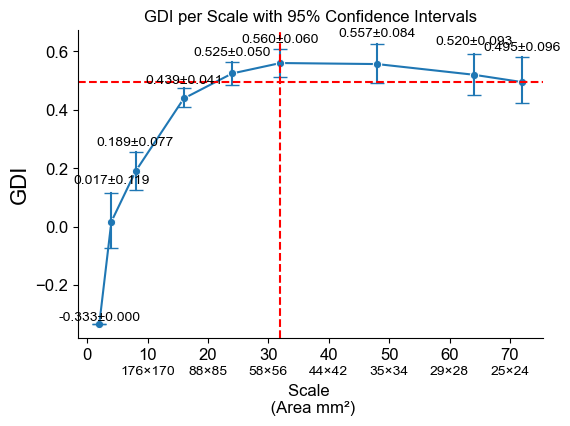

In [31]:
# Calculate mean and confidence interval manually
grouped = df_melted.groupby('Scale')
mean_values = grouped['Diversity Value'].mean()
conf_intervals = grouped['Diversity Value'].apply(lambda x: stats.sem(x) * stats.t.ppf((1 + 0.95) / 2., len(x)-1))

# Plotting using sns.lineplot
plt.figure(figsize=(6, 4))
ax = sns.lineplot(data=df_melted, 
                  x='Scale', 
                  y='Diversity Value', 
                  style='sample',
                  markers=True,
                  estimator='mean', 
                  err_style='bars', 
                  errorbar=("ci", 95),
                  err_kws={"capsize":5.0}
                 )

# Annotating error bars with their value
for i, (scale, mean, ci) in enumerate(zip(mean_values.index, mean_values, conf_intervals)):
    ax.text(scale, mean + ci, f'{mean:.3f}±{ci:.3f}', color='black', ha='center', va='bottom')

# Drawing red dashed horizontal lines at half the maximum of x and y axes
mean_diversity_per_scale = df_melted.groupby('Scale')['Diversity Value'].mean()
y_sep = mean_diversity_per_scale.max() / 2
y_sep = mean_diversity_per_scale.median()
x_sep = mean_diversity_per_scale.idxmax()

# y_sep = df_melted.iloc[df_melted['Diversity Value'].idxmax()]['Diversity Value']/2
# x_sep = df_melted.iloc[df_melted['Diversity Value'].idxmax()]['Scale']
ax.axhline(y_sep, color='red', linestyle='--')
ax.axvline(x_sep, color='red', linestyle='--')

# Remove the legend
ax.get_legend().remove()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('', fontsize=0)
plt.xticks(fontsize=12)
plt.ylabel(f"GDI", fontsize=16)
plt.yticks(fontsize=12)

# Add secondary x-axis
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()][2:-1]
scales = [int(label) for label in xtick_labels if label.strip() != '']
x_sizes = [mean_xrange / scale for scale in scales]
y_sizes = [mean_yrange / scale for scale in scales]
size_labels = [f"{int(x_size)}×{int(y_size)}" for x_size, y_size in zip(x_sizes, y_sizes)]
secax = ax.secondary_xaxis(location=-0.075)
secax.set_xticks(scales)
secax.set_xticklabels(size_labels)
secax.tick_params('x', length=0)
secax.spines['bottom'].set_linewidth(0)
secax.set_xlabel(f'Scale \n (Area μm²)', fontsize=12)

plt.title(f'GDI per Scale with 95% Confidence Intervals')
plt.grid(False)
fig = plt.gcf()
fig.savefig('../figures/mice/spleen_scale_selection.svg')
plt.show()


# Calculate Proximity Index

In [13]:
Hot = True
library_names = ['BALBc', 'MRL'] 
library_ids = [['BALBc-1', 'BALBc-2', 'BALBc-3'], ['MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']]
PX_results = []


for library, library_name in zip(library_ids, library_names):
    proximity_I = msd.sample_proximity(spatial_data=adata, 
                                       scale=64.0, 
                                       library_key='sample',
                                       library_ids=library, 
                                       spatial_key='spatial',
                                       cluster_key='cell_type',
                                       hotspot=Hot,
                                       metric='Shannon Diversity')
    # Store PX 
    PX_results.append(proximity_I)


Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Region BALBc-1 contains 687 diversity hotspots
48 islands identified
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Region BALBc-2 contains 851 diversity hotspots
47 islands identified
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Region BALBc-3 contains 712 diversity hotspots
46 islands identified
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Region MRL-4 contains 480 diversity hotspots
53 islands identified
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Region MRL-5 contains 443 diversity hotspots
43 islands identified
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Region MRL-6 contains 326 diversity hotspots
61 islands identified
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Region MRL-7 contains 499 diversity hotspots
46 islands identified
Processing regi

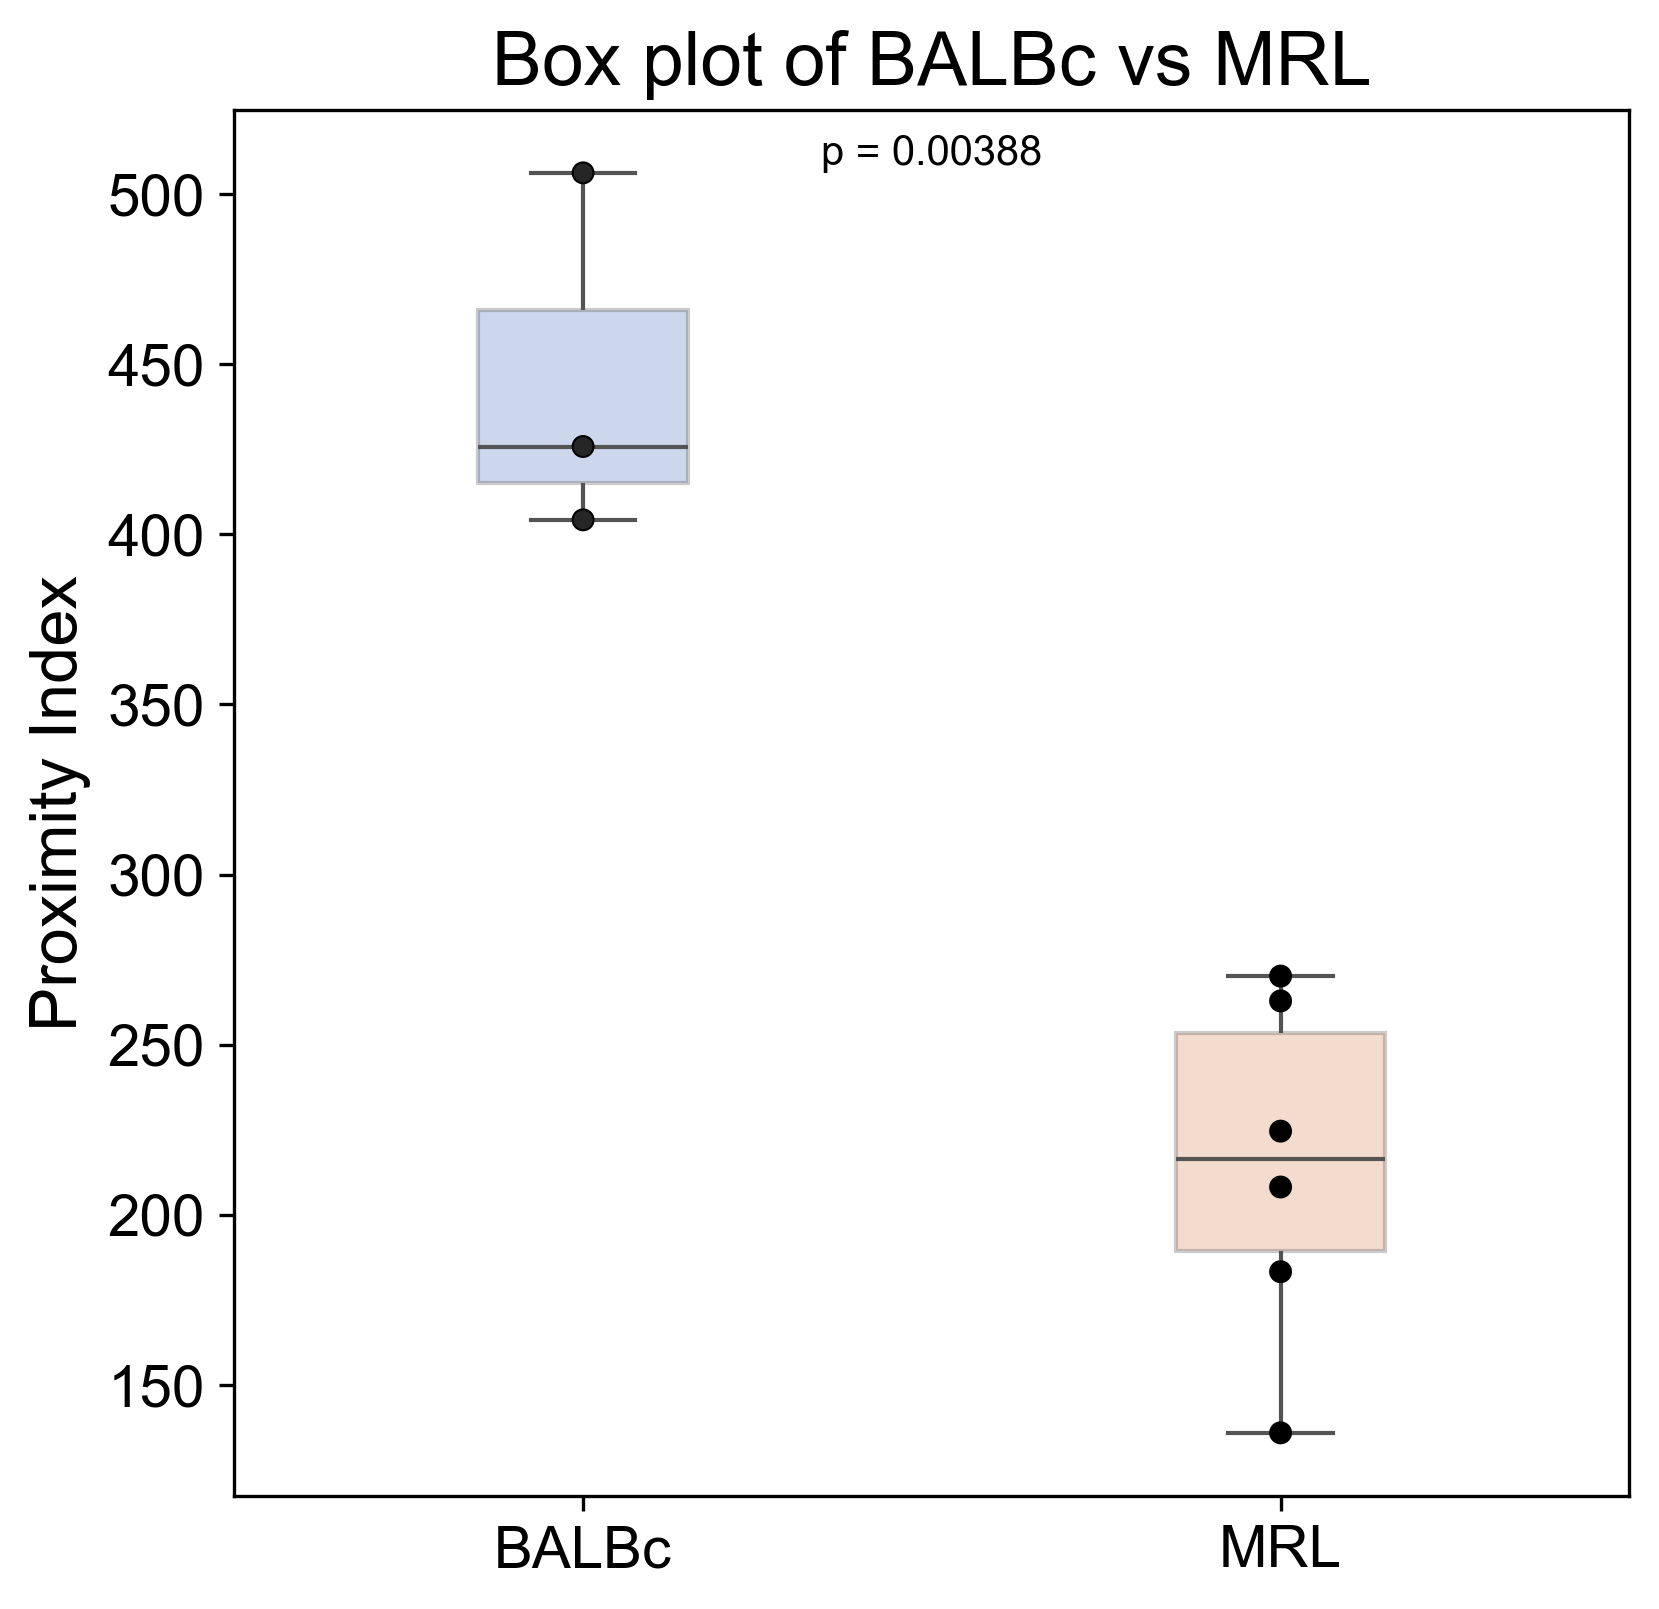

In [14]:
if Hot:
    save_path = 'HotIslands_Proximity_Index.svg'
else:
    save_path = 'ColdIslands_Proximity_Index.svg'
    
# Extract data for boxplot
balbc_data = [v[0] for k, v in PX_results[0].items()]
mrl_data = [v[0] for k, v in PX_results[1].items()]

# Mann-Whitney U test
#stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data) # p=0.02381
stat, p_value = stats.ttest_ind(balbc_data, mrl_data,equal_var=False) # p=0.01381

# Combining data
data = [balbc_data, mrl_data]
labels = ['BALBc', 'MRL']

# Plotting
plt.figure(figsize=(6, 6), dpi=300)  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Proximity Index", fontsize=16)
plt.title('Box plot of BALBc vs MRL', fontsize=18)


# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.5f}', horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
# fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

In [15]:
data

[[404.2542556417613, 506.2519207394475, 425.808947487993],
 [270.15183997103037,
  224.5755423497343,
  135.89604061638005,
  262.84453706879515,
  183.2555995228033,
  208.1517594195881]]

# Global Cell-type Frequency

In [9]:
adata_df = adata.obs[['cell_type', 'sample']]
adata_df = adata_df.assign(group=[ 'BALBc' if 'BALBc' in name else 'MRL' for name in adata_df['sample']])

# Filter for desired cell types
selected_cell_types = sorted(adata_df['cell_type'].unique())

filtered_df = adata_df[adata_df['cell_type'].isin(selected_cell_types)]

# Compute cell type frequencies for each sample
global_cell_count = filtered_df.groupby(['sample', 'cell_type']).size().unstack(fill_value=0)
grouped_freq = global_cell_count.div(global_cell_count.sum(axis=1), axis=0)

# Add the group info back to this normalized dataframe
grouped_freq['group'] = [ 'BALBc' if 'BALBc' in name else 'MRL' for name in grouped_freq.index]

# Melt the dataframe for easier plotting and statistical analysis
global_freq = grouped_freq.reset_index().melt(id_vars=['sample', 'group'], value_vars=selected_cell_types)
global_freq.columns = ['sample', 'group', 'cell_type', 'Frequency']

global_freq

sample  group     cell_type  Frequency
0    BALBc-1  BALBc       B cells   0.426889
1    BALBc-2  BALBc       B cells   0.409448
2    BALBc-3  BALBc       B cells   0.400763
3      MRL-4    MRL       B cells   0.378136
4      MRL-5    MRL       B cells   0.218244
..       ...    ...           ...        ...
238    MRL-5    MRL  plasma cells   0.003016
239    MRL-6    MRL  plasma cells   0.013661
240    MRL-7    MRL  plasma cells   0.003686
241    MRL-8    MRL  plasma cells   0.016240
242    MRL-9    MRL  plasma cells   0.006100

[243 rows x 4 columns]

B cells has p value of 0.006408963135728074
B220(+) DN T cells has p value of 0.08363460243637065
CD106(+)CD16/32(+)CD31(+) stroma has p value of 0.10246220899780342
CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value of 0.04098951744156447
CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value of 0.48760707221130684
CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value of 0.00014746290448731814
CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma has p value of 0.029644306916028648
CD11c(+) B cells has p value of 0.04433015687789797
CD3(+) other markers (-) has p value of 0.0039461017917897965
CD31(hi) vascular has p value of 0.744873603519344
CD4(+) T cells has p value of 0.23629828012676266
CD4(+)CD8(-)cDC has p value of 0.002101995902806824
CD4(+)MHCII(+) has p value of 0.27737999550550363
CD4(-)CD8(+)cDC has p value of 0.00013225110887609995
CD4(-)CD8(-) cDC has p value of 0.13322938432638706
CD8(+) T cells has p value of 0.8144572874311375
ERTR7(+) stroma has p value of 0.5151830491689221
F4/80(+) mphs has p va

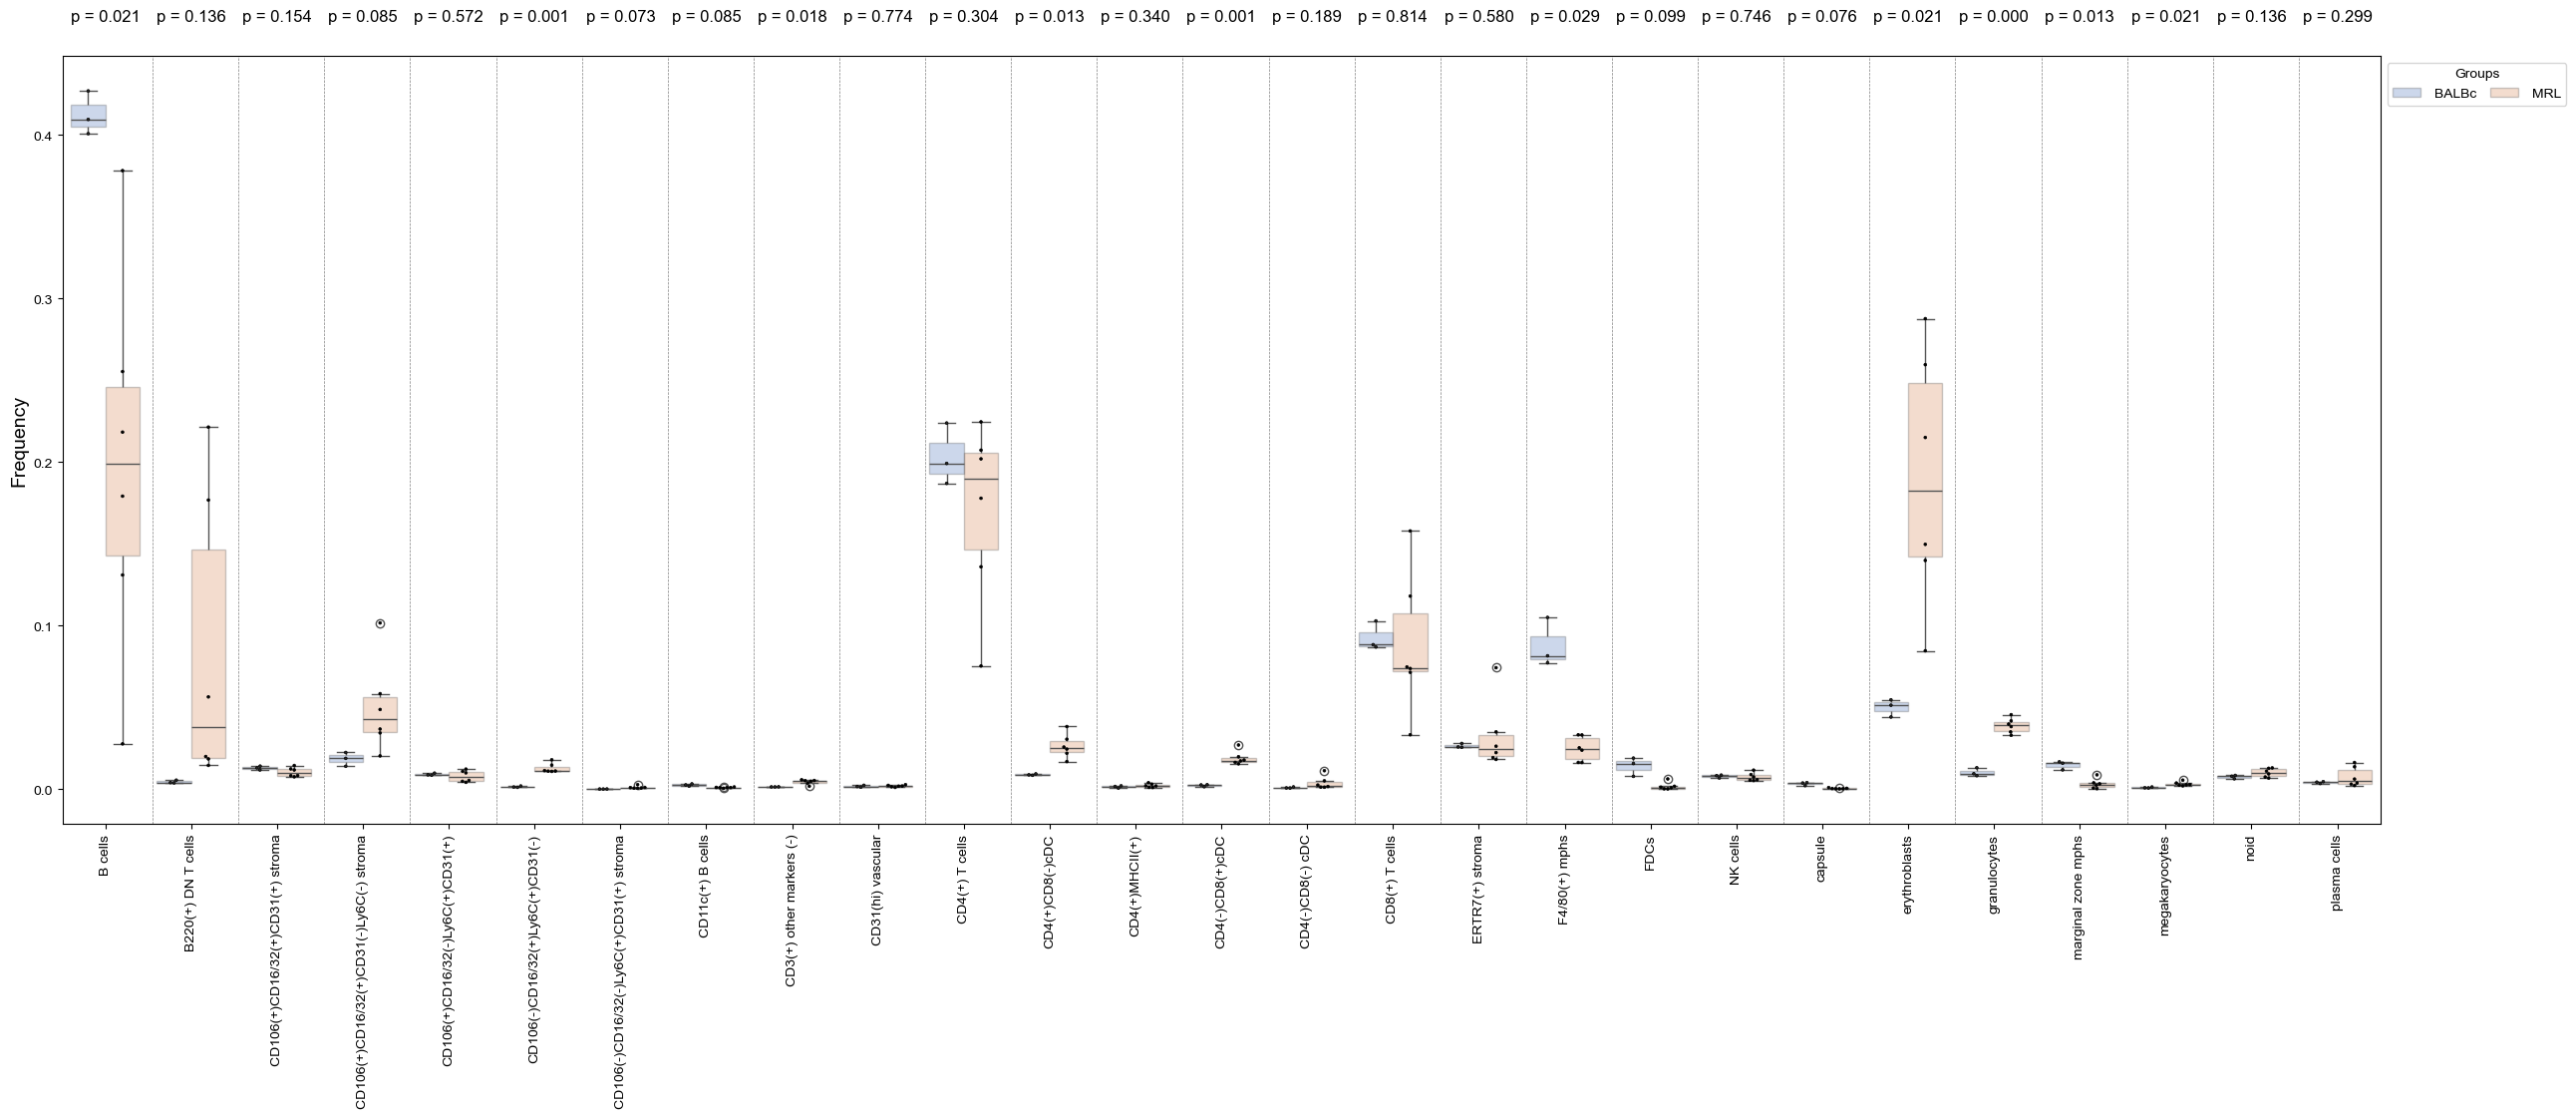

In [12]:
# Perform t-tests
selected_p_values = []
for ct in selected_cell_types:
    group1 = global_freq[(global_freq['cell_type'] == ct) & (global_freq['group'] == 'BALBc')]['Frequency']
    group2 = global_freq[(global_freq['cell_type'] == ct) & (global_freq['group'] == 'MRL')]['Frequency']
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value of {p_value}")
    selected_p_values.append(p_value)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
print('-'*42)
print(f"p-values after correction:")

# Plot
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=global_freq, x='cell_type', y='Frequency', hue='group', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=global_freq, x='cell_type', y='Frequency', hue='group', palette='dark:black', size=2.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=90)

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('') 

# save_path = 'global_celltype_freq.svg'
# plt.savefig('../figures/mice/'+save_path)
plt.show()


# Global Cell Comb Frequency

In [8]:
Hot = True
library_names = ['BALBc', 'MRL'] 
library_ids = [['BALBc-1', 'BALBc-2', 'BALBc-3'], ['MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']]
comp_results = []
comp_results_mice = []
moran_results = []

comb_freq_results = []
comb_freq_results_mice = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=adata, 
                                                                              scale=64.0, 
                                                                              library_key='sample',
                                                                              library_ids=library, 
                                                                              spatial_key='spatial',
                                                                              cluster_key='cell_type',
                                                                              hotspot=Hot,
                                                                              whole_tissue=True,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    total_merged_series = pd.concat(total_comp_dict.values(), axis=1).sum(axis=1)
    comp_results.append(total_merged_series)
    comb_freq_results.append(spot_comb_dict)
    
    # Store Moran's I 
    moran_results.append(global_morans)
    
    # Calculate cell-type/combination freq in hotspots
    comp_mice = pd.DataFrame()
    comb_mice = pd.DataFrame()
    
    
    for key in total_comp_dict.keys():
        comp_mice = append_series_to_df(comp_mice, (total_comp_dict[key]/total_comp_dict[key].sum(axis=0)), key)
        comb_mice = append_series_to_df(comb_mice, spot_comb_dict[key], key)
        
    comp_mice = comp_mice.T    
    comp_mice['Condition'] = library_name 
    comp_results_mice.append(comp_mice.fillna(0))
    
    comb_mice = comb_mice.T
    comb_mice['Condition'] = library_name
    comb_freq_results_mice.append(comb_mice.fillna(0))

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Region BALBc-1 contains 687 diversity hotspots
Considering whole tissue
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Region BALBc-2 contains 851 diversity hotspots
Considering whole tissue
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Region BALBc-3 contains 712 diversity hotspots
Considering whole tissue
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Region MRL-4 contains 480 diversity hotspots
Considering whole tissue
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Region MRL-5 contains 443 diversity hotspots
Considering whole tissue
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Region MRL-6 contains 326 diversity hotspots
Considering whole tissue
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Region MRL-7 contains 499 diversity hotspots
Considering whole t

In [9]:
global_df1 = comb_freq_results_mice[0]
global_df2 = comb_freq_results_mice[1]

# get the union of columns
columns = global_df1.columns.union(global_df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
global_df1 = global_df1.reindex(columns=columns).fillna(0)
global_df2 = global_df2.reindex(columns=columns).fillna(0)

351


In [10]:
temp = pd.concat([global_df1, global_df2],axis=0)
temp = temp.sort_index(axis=1) 
condition_col = temp['Condition']
temp = temp.drop(columns='Condition')

global_comb_df = temp.loc[:, (temp[temp.columns.difference([('Condition','')])].mean() > 0.05)].copy()
global_comb_df['Condition'] = condition_col
global_comb_df['Mouse'] = global_comb_df.index
global_comb_df.sort_index(axis=1,inplace=True)

In [11]:
global_subset_cols = global_comb_df.columns

In [13]:
global_comb_df

B cells                                   \
        B220(+) DN T cells CD106(+)CD16/32(+)CD31(+) stroma   
BALBc-1           0.064419                         0.160549   
BALBc-2           0.066425                         0.147066   
BALBc-3           0.089248                         0.157044   
MRL-4             0.144332                         0.124170   
MRL-5             0.108434                         0.023359   
MRL-6             0.233178                         0.084414   
MRL-7             0.105212                         0.035478   
MRL-8             0.370235                         0.059384   
MRL-9             0.183838                         0.031250   

                                                 \
        CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma   
BALBc-1                                0.305368   
BALBc-2                                0.261825   
BALBc-3                                0.202331   
MRL-4                                  0.279075   
MRL-5                                  0.137202   
MRL-6                                  0.247370   
MRL-7                                  0.090531   
MRL-8                                  0.240469   
MRL-9                                  0.126221   

                                                                         \
        CD106(+)CD16/32(-)Ly6C(+)CD31(+) CD4(+) T cells CD4(+)CD8(-)cDC   
BALBc-1                         0.118851       0.633708        0.142322   
BALBc-2                         0.111398       0.599121        0.131300   
BALBc-3                         0.121028       0.595604        0.126589   
MRL-4                           0.104500       0.462749        0.205803   
MRL-5                           0.054340       0.308335        0.122203   
MRL-6                           0.050404       0.506239        0.127477   
MRL-7                           0.035234       0.320284        0.143871   
MRL-8                           0.096774       0.494379        0.161046   
MRL-9                           0.022949       0.202148        0.084229   

                                                                      ...  \
        CD4(-)CD8(+)cDC CD8(+) T cells ERTR7(+) stroma F4/80(+) mphs  ...   
BALBc-1        0.039700       0.434956        0.230462      0.504619  ...   
BALBc-2        0.040320       0.448695        0.228224      0.560352  ...   
BALBc-3        0.020657       0.423464        0.206568      0.465837  ...   
MRL-4          0.157118       0.321613        0.263093      0.306614  ...   
MRL-5          0.123433       0.235063        0.077453      0.129334  ...   
MRL-6          0.142158       0.364815        0.154881      0.225349  ...   
MRL-7          0.095180       0.233668        0.096159      0.152679  ...   
MRL-8          0.127322       0.338465        0.142962      0.153715  ...   
MRL-9          0.045410       0.143311        0.133301      0.057617  ...   

        ERTR7(+) stroma              F4/80(+) mphs                             \
          erythroblasts granulocytes      NK cells erythroblasts granulocytes   
BALBc-1        0.150562     0.037703      0.113109      0.361798     0.110112   
BALBc-2        0.170845     0.045231      0.128974      0.440941     0.153011   
BALBc-3        0.158369     0.030191      0.099047      0.376324     0.097987   
MRL-4          0.240226     0.137202      0.090976      0.328989     0.173101   
MRL-5          0.095156     0.054586      0.046963      0.232850     0.119007   
MRL-6          0.140690     0.071691      0.046489      0.308050     0.165892   
MRL-7          0.153658     0.086127      0.045265      0.279912     0.147296   
MRL-8          0.124145     0.064272      0.043011      0.177908     0.094330   
MRL-9          0.347656     0.199219      0.024414      0.179932     0.104248   

                     Mouse      NK cells erythroblasts            
             noid          erythroblasts  granulocytes      noid  
BALBc-1  0.083895  BALBc-1      0.095880      0.091885  0.06691

In [20]:
# Runthe Hot/Cold Spot Calculation to get spot_subset_cols
union_cols = set(global_subset_cols).union(set(spot_subset_cols))
global_comb_df = pd.concat([global_df1, global_df2],axis=0)
global_comb_df['Mouse'] = global_comb_df.index
global_comb_df = global_comb_df.reindex(columns=union_cols)

In [23]:
global_comb_df[('B cells','CD106(-)CD16/32(+)Ly6C(+)CD31(-)')] # 之前被filter掉的又加回来了

BALBc-1    0.023471
BALBc-2    0.034117
BALBc-3    0.020657
MRL-4      0.082862
MRL-5      0.040816
MRL-6      0.079031
MRL-7      0.029851
MRL-8      0.049853
MRL-9      0.026611
Name: (B cells, CD106(-)CD16/32(+)Ly6C(+)CD31(-)), dtype: float64

In [36]:
count = calculate_interactions(global_comb_df)
sorted_count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1],reverse=True)}
print(sorted_count)

{'CD4(+) T cells': 16, 'B cells': 15, 'erythroblasts': 15, 'F4/80(+) mphs': 14, 'CD8(+) T cells': 14, 'CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma': 13, 'B220(+) DN T cells': 9, 'ERTR7(+) stroma': 9, 'CD4(+)CD8(-)cDC': 9, 'granulocytes': 9, 'noid': 6, 'CD4(-)CD8(+)cDC': 6, 'CD106(+)CD16/32(+)CD31(+) stroma': 6, 'CD106(-)CD16/32(+)Ly6C(+)CD31(-)': 5, 'CD106(+)CD16/32(-)Ly6C(+)CD31(+)': 5, 'NK cells': 5, '': 2, 'marginal zone mphs': 2, 'Mouse': 1, 'Condition': 1}


In [18]:
# Multi-index to single-index column
new_columns = []
for col in global_comb_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "Mouse" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)
global_comb_df.columns = new_columns

global_comb_df = global_comb_df[[col for col in global_comb_df.columns if 'noid' not in col]]

# Melt the DataFrame
grouped_melted = global_comb_df.melt(id_vars=['Mouse', 'Condition'], var_name='CellType', value_name='Frequency')


In [19]:
# grouped_melted.drop(grouped_melted[grouped_melted['Frequency'] <= 1].index, inplace=True)
grouped_melted

Mouse Condition                        CellType  Frequency
0    BALBc-1     BALBc  CD4(+) T cells&CD4(-)CD8(+)cDC   0.031461
1    BALBc-2     BALBc  CD4(+) T cells&CD4(-)CD8(+)cDC   0.038253
2    BALBc-3     BALBc  CD4(+) T cells&CD4(-)CD8(+)cDC   0.023040
3      MRL-4       MRL  CD4(+) T cells&CD4(-)CD8(+)cDC   0.130317
4      MRL-5       MRL  CD4(+) T cells&CD4(-)CD8(+)cDC   0.189329
..       ...       ...                             ...        ...
976    MRL-5       MRL      erythroblasts&plasma cells   0.024096
977    MRL-6       MRL      erythroblasts&plasma cells   0.057255
978    MRL-7       MRL      erythroblasts&plasma cells   0.036457
979    MRL-8       MRL      erythroblasts&plasma cells   0.084800
980    MRL-9       MRL      erythroblasts&plasma cells   0.052002

[981 rows x 4 columns]

p-value before correction:
B cells&B220(+) DN T cells has p value = 0.034
B cells&CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.001
B cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.161
B cells&CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.008
B cells&CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.053
B cells&CD3(+) other markers (-) has p value = 0.236
B cells&CD4(+) T cells has p value = 0.006
B cells&CD4(+)CD8(-)cDC has p value = 0.686
B cells&CD4(-)CD8(+)cDC has p value = 0.003
B cells&CD8(+) T cells has p value = 0.004
B cells&ERTR7(+) stroma has p value = 0.033
B cells&F4/80(+) mphs has p value = 0.000
B cells&NK cells has p value = 0.006
B cells&erythroblasts has p value = 0.031
B cells&granulocytes has p value = 0.960
B cells&marginal zone mphs has p value = 0.004
B cells&plasma cells has p value = 0.232
B220(+) DN T cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.041
B220(+) DN T cells&CD4(+) T cells has p value = 0.031
B220(+) DN T cells&CD

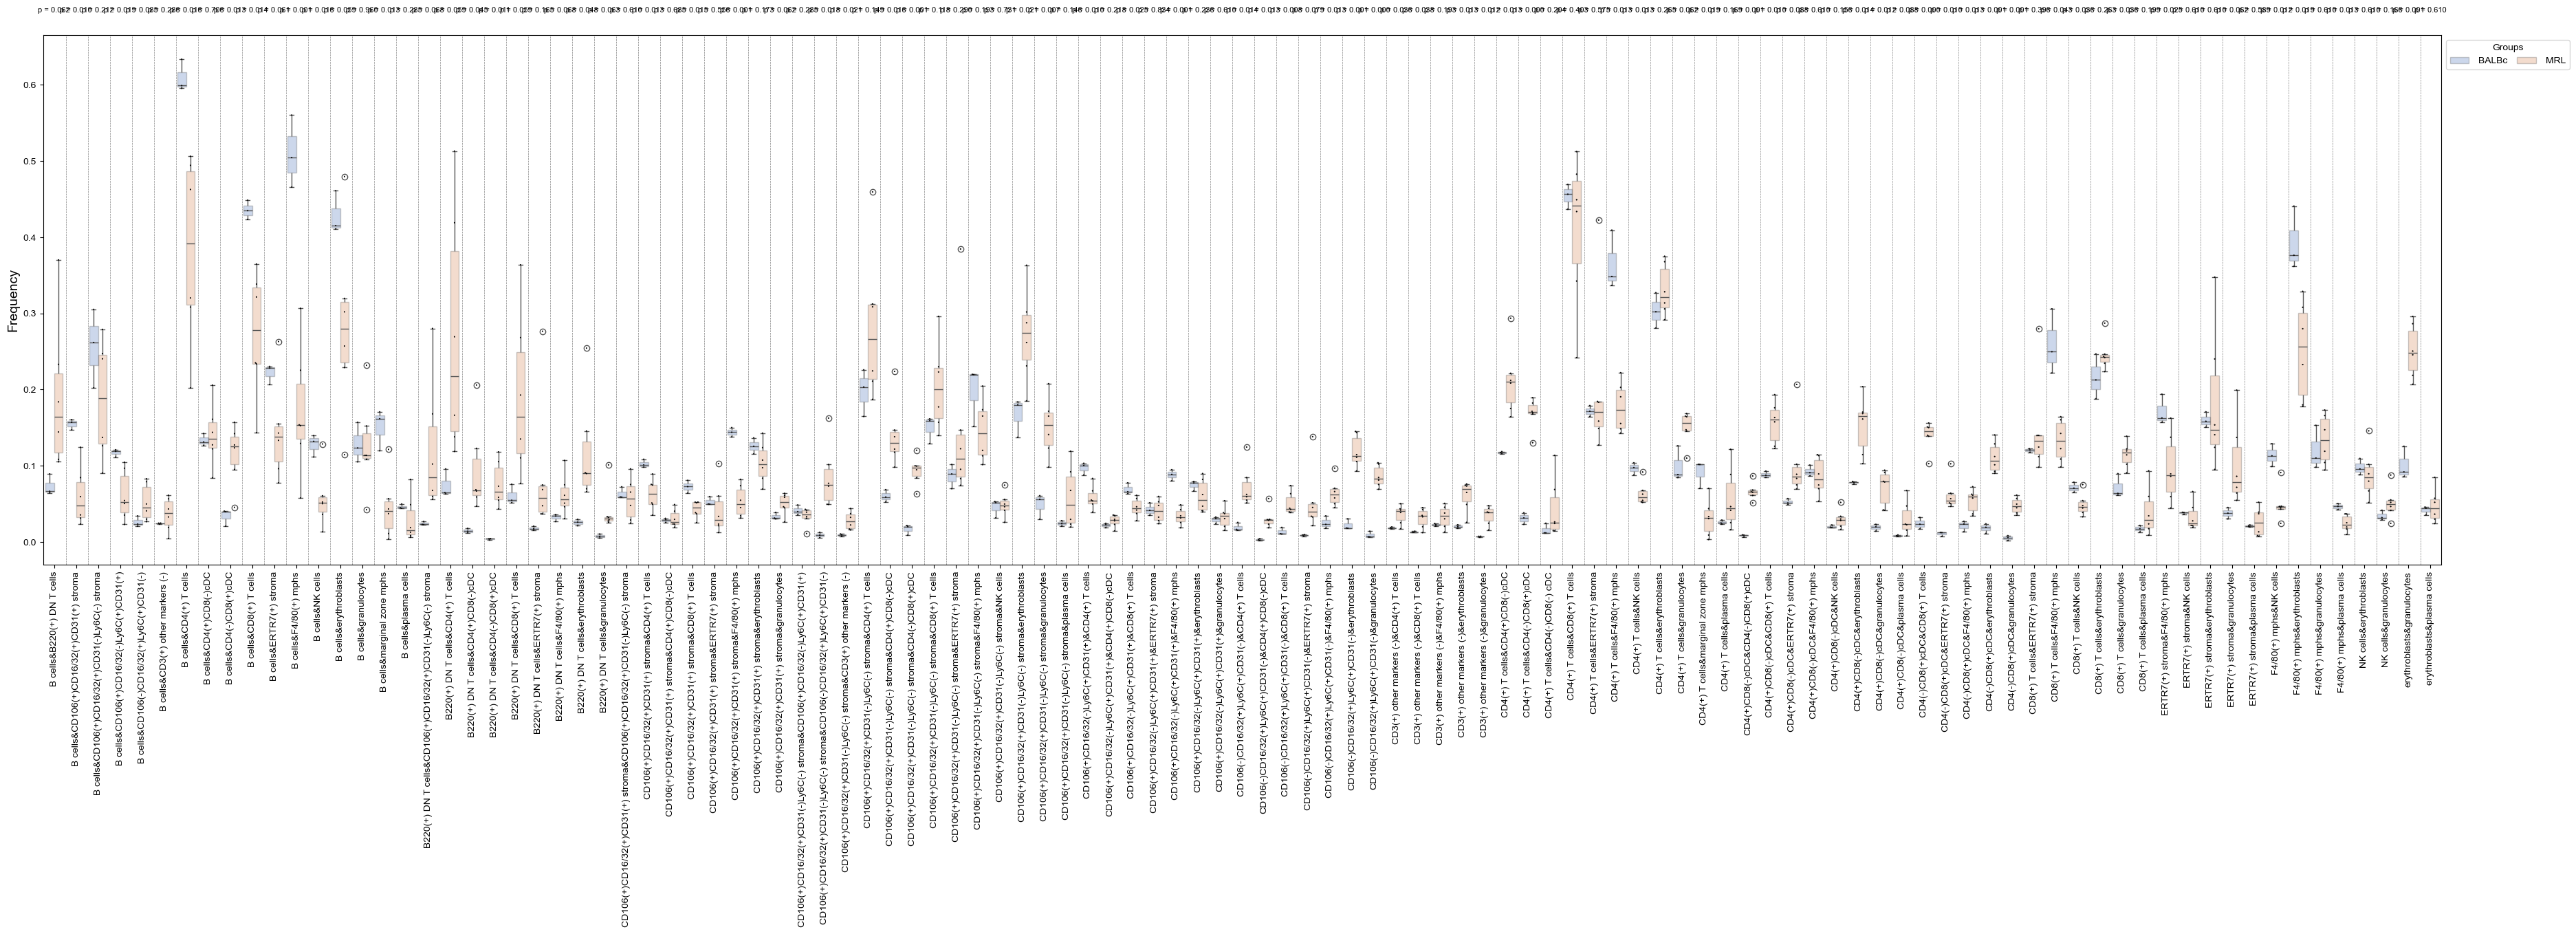

In [20]:
if Hot:
    save_path = 'tissue_celltype_comb_freq.svg'
else:
    save_path = 'coldspot_celltype_comb_freq.svg'
    
selected_cell_types = sorted(grouped_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types:
    subset = grouped_melted[grouped_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
grouped_filtered = grouped_melted[grouped_melted['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(45,10))
sns.boxplot(data=grouped_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=grouped_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
# fig.savefig('../figures/mice/'+save_path)
plt.show()
plt.close(fig)


In [43]:
circoplot_df1 = global_comb_df.drop(columns=['Mouse'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'noid' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_57080/3217377496.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  circoplot_df1 = global_comb_df.drop(columns=['Mouse'])
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_57080/3217377496.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()


B cells CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  \
          ERTR7(+) stroma                            plasma cells   
Condition                                                           
BALBc            0.221751                                0.024180   
MRL              0.144641                                0.058505   

          CD106(+)CD16/32(-)Ly6C(+)CD31(+)   CD4(+) T cells  \
                           ERTR7(+) stroma CD4(-)CD8(-) cDC   
Condition                                                     
BALBc                             0.042573         0.016152   
MRL                               0.040823         0.043742   

          CD106(+)CD16/32(+)CD31(+) stroma CD4(+) T cells  \
                           ERTR7(+) stroma       NK cells   
Condition                                                   
BALBc                             0.053053       0.096485   
MRL                               0.042264       0.063546   

          CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma       B cells  \
                                   CD4(+) T cells erythroblasts   
Condition                                                         
BALBc                                    0.198035      0.429028   
MRL                                      0.283869      0.283689   

          CD3(+) other markers (-) F4/80(+) mphs  ...  \
                      granulocytes erythroblasts  ...   
Condition                                         ...   
BALBc                     0.006968      0.393021  ...   
MRL                       0.034987      0.251273  ...   

          CD3(+) other markers (-) CD4(+) T cells  \
                    CD8(+) T cells  F4/80(+) mphs   
Condition                                           
BALBc                     0.013145       0.364918   
MRL                       0.031226       0.177093   

                                   B cells  CD4(+) T cells  \
          CD106(+)CD16/32(+)CD31(+) stroma ERTR7(+) stroma   
Condition                                                    
BALBc                             0.154887        0.171759   
MRL                               0.059676        0.204170   

                                   B cells erythroblasts ERTR7(+) stroma  \
          CD106(+)CD16/32(-)Ly6C(+)CD31(+)  granulocytes    plasma cells   
Condition                                                                  
BALBc                             0.117092      0.101013        0.020787   
MRL                               0.060700      0.250753        0.026166   

          CD4(+) T cells CD8(+) T cells  CD4(+) T cells  
           erythroblasts       NK cells CD4(+)CD8(-)cDC  
Condition                                                
BALBc           0.303429       0.071375        0.117150  
MRL             0.330463       0.048890        0.212534  

[2 rows x 109 columns]

In [46]:
circoplot_df2 = circoplot_df2[[col for col in circoplot_df2.columns if 'noid' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

B cells  B220(+) DN T cells  CD106(+)CD16/32(+)CD31(+) stroma  \
Condition                                                                   
BALBc      0.286122            0.003563                          0.024994   
MRL        0.090528            0.026797                          0.012673   

           CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  \
Condition                                            
BALBc                                     0.035697   
MRL                                       0.102604   

           CD106(+)CD16/32(-)Ly6C(+)CD31(+)  CD106(-)CD16/32(+)Ly6C(+)CD31(-)  \
Condition                                                                       
BALBc                              0.015001                          0.003794   
MRL                                0.014580                          0.026811   

           CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma  CD11c(+) B cells  \
Condition                                                              
BALBc                                     0.000047          0.003634   
MRL                                       0.003775          0.001113   

           CD3(+) other markers (-)  CD31(hi) vascular  ...  ERTR7(+) stroma  \
Condition                                               ...                    
BALBc                      0.003974           0.002357  ...         0.046011   
MRL                        0.009032           0.004166  ...         0.063478   

           F4/80(+) mphs      FDCs  NK cells   capsule  erythroblasts  \
Condition                                                               
BALBc            0.19085  0.000028  0.017559  0.001526       0.108952   
MRL              0.04965  0.000058  0.013987  0.000819       0.150498   

           granulocytes  marginal zone mphs  megakaryocytes  plasma cells  
Condition                                                                  
BALBc          0.026025            0.004240        0.001321      0.011325  
MRL            0.074897            0.001001        0.005919      0.017193  

[2 rows x 26 columns]

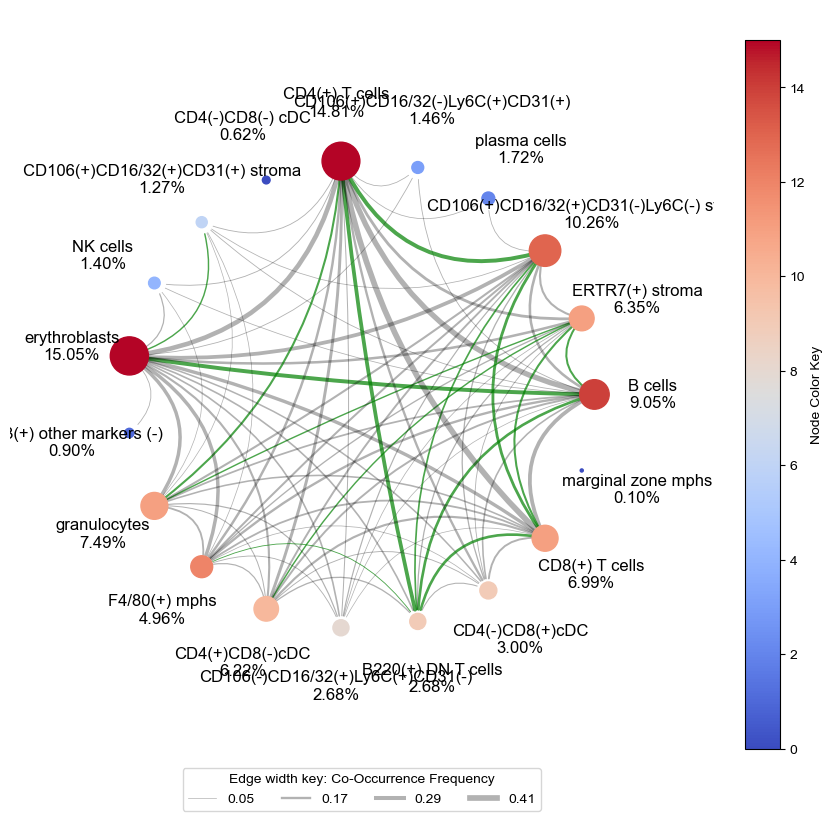

In [48]:
patient_group = 'MRL'
cirplot_save_path = '../figures/mice/wholetissue_circleplot_'+ patient_group +'.svg'

msd.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path=cirplot_save_path)

# Hot/Cold Spot Cellular analysis

## Calculattion

In [10]:
Hot = True
library_names = ['BALBc', 'MRL'] 
library_ids = [['BALBc-1', 'BALBc-2', 'BALBc-3'], ['MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']]

total_merged_series = []

comp_results_mice = []
moran_results = []

comb_freq_results = []
comb_freq_results_mice = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=adata, 
                                                                              scale=64.0, 
                                                                              library_key='sample',
                                                                              library_ids=library, 
                                                                              spatial_key='spatial',
                                                                              cluster_key='cell_type',
                                                                              hotspot=Hot,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              restricted=False,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    total_merged_series.append(total_comp_dict)
    comb_freq_results.append(spot_comb_dict)
    
    # Store Moran's I 
    moran_results.append(global_morans)
    
    # Calculate cell-type/combination freq in hotspots
    comp_mice = pd.DataFrame()
    comb_mice = pd.DataFrame()
    
    for key in total_comp_dict.keys():
        comp_mice = append_series_to_df(comp_mice, (total_comp_dict[key]/total_comp_dict[key].sum(axis=0)), key)
        comb_mice = append_series_to_df(comb_mice, spot_comb_dict[key], key)
        
    comp_mice = comp_mice.T    
    comp_mice['Condition'] = library_name 
    comp_results_mice.append(comp_mice.fillna(0))
    
    comb_mice = comb_mice.T
    comb_mice['Condition'] = library_name
    comb_freq_results_mice.append(comb_mice.fillna(0))

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Region BALBc-1 contains 687 diversity hotspots
Considering only hotspots
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Region BALBc-2 contains 851 diversity hotspots
Considering only hotspots
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Region BALBc-3 contains 712 diversity hotspots
Considering only hotspots
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Region MRL-4 contains 480 diversity hotspots
Considering only hotspots
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Region MRL-5 contains 443 diversity hotspots
Considering only hotspots
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Region MRL-6 contains 326 diversity hotspots
Considering only hotspots
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Region MRL-7 contains 499 diversity hotspots
Considering o

## GDCI Boxplots

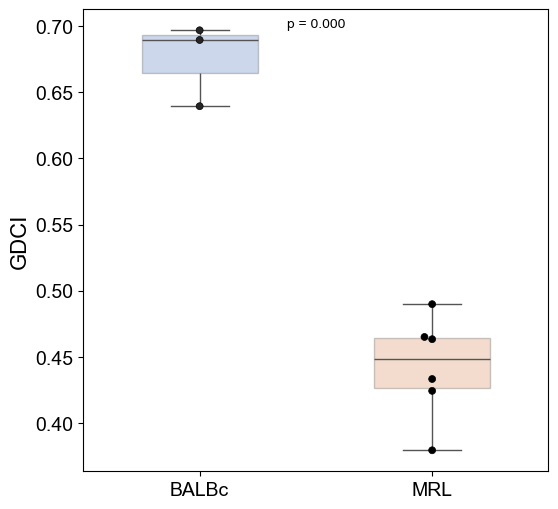

In [11]:
# Extract data for boxplot
balbc_data = [v[0] for k, v in moran_results[0].items()]
mrl_data = [v[0] for k, v in moran_results[1].items()]

# Mann-Whitney U test
# stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data)
stat, p_value = stats.ttest_ind(balbc_data, mrl_data, equal_var=False)

# Combining data
data = [balbc_data, mrl_data]
labels = ['BALBc', 'MRL']

# Plotting
plt.figure(figsize=(6, 6)) 
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.5)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)

plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("GDCI", fontsize=16)
# plt.title(f'{mode}', fontsize=18)

# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')
save_path = 'GDCI.svg'
fig = plt.gcf()
# fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

In [12]:
data 

[[0.6394073959995283, 0.6894333565566296, 0.6967598932501694],
 [0.4898708654781263,
  0.46509275357947344,
  0.42436831975058675,
  0.4634155693162985,
  0.3794937224532291,
  0.4333355562627946]]

## process and visualise proportion of cells in hot/cold

Processing BALBc-1
Processing BALBc-2
Processing BALBc-3
Processing MRL-4
Processing MRL-5
Processing MRL-6
Processing MRL-7
Processing MRL-8
Processing MRL-9


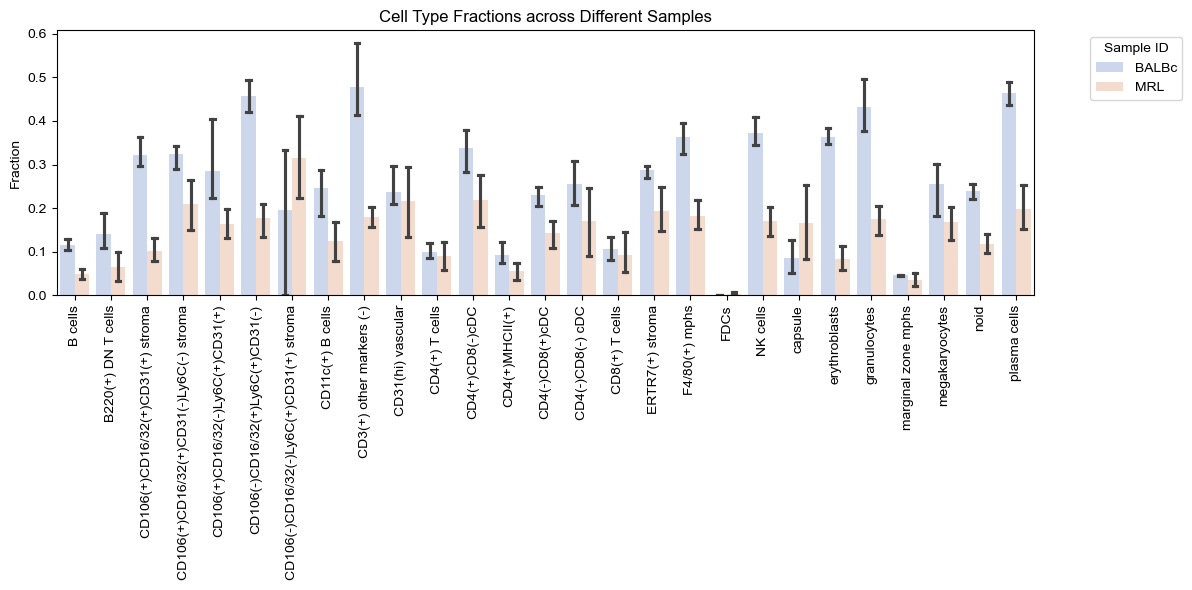

In [11]:
spot_fraction_data = []
for sample_group in total_merged_series:
    for ids in sample_group.keys():
        print(f'Processing {ids}')
        # print(sample_group[ids])
        # print(global_cell_count.loc[ids])
        fraction = (sample_group[ids]/global_cell_count.loc[ids]).fillna(0)
        fraction_df = fraction.to_frame(name='fraction')
        fraction_df['sample_id'] = ids.split('-')[0]
        fraction_df['cell_type'] = fraction_df.index
        spot_fraction_data.append(fraction_df)
        # print(fraction_df)
        # print('-'*42)
spot_fraction_df = pd.concat(spot_fraction_data)

# Transform DataFrame for plotting
spot_fraction_df_long = spot_fraction_df.melt(id_vars=['sample_id', 'cell_type'], value_vars=['fraction'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='cell_type', y='value', hue='sample_id', 
            data=spot_fraction_df_long, palette='muted', 
            alpha=0.3, capsize=0.25)

# Customize the plot
plt.title('Cell Type Fractions across Different Samples')
plt.xlabel('')
plt.ylabel('Fraction')
plt.xticks(rotation=90)
plt.legend(title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
fig = plt.gcf()
if Hot:
    save_path = 'hotspot_frac.svg'
else:
    save_path = 'coldspot_frac.svg'
# fig.savefig('../figures/mice/'+save_path)
plt.show()

## process and visualise cell frequency

In [10]:
df1 = comp_results_mice[0]
df2 = comp_results_mice[1]

# get the union of columns
columns = df1.columns.union(df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
df1 = df1.reindex(columns=columns).fillna(0)
df2 = df2.reindex(columns=columns).fillna(0)

28


In [11]:
df_abundance = pd.concat([df1, df2],axis=0)
df_abundance['Mouse'] = df_abundance.index
df_abundance = df_abundance.drop(columns='noid')

In [12]:
df_abundance

B cells  B220(+) DN T cells  CD106(+)CD16/32(+)CD31(+) stroma  \
BALBc-1  0.301445            0.003322                          0.027072   
BALBc-2  0.273973            0.003664                          0.021984   
BALBc-3  0.282948            0.003704                          0.025926   
MRL-4    0.133904            0.015103                          0.015103   
MRL-5    0.089479            0.022081                          0.006061   
MRL-6    0.111169            0.013809                          0.014858   
MRL-7    0.087740            0.019511                          0.006350   
MRL-8    0.096830            0.037242                          0.007968   
MRL-9    0.024049            0.053039                          0.025696   

         CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  \
BALBc-1                                 0.044262   
BALBc-2                                 0.033354   
BALBc-3                                 0.029475   
MRL-4                                   0.075633   
MRL-5                                   0.101602   
MRL-6                                   0.097011   
MRL-7                                   0.057723   
MRL-8                                   0.117616   
MRL-9                                   0.166035   

         CD106(+)CD16/32(-)Ly6C(+)CD31(+)  CD106(-)CD16/32(+)Ly6C(+)CD31(-)  \
BALBc-1                          0.013287                          0.003571   
BALBc-2                          0.017751                          0.004801   
BALBc-3                          0.013966                          0.003009   
MRL-4                            0.021049                          0.022119   
MRL-5                            0.018617                          0.018906   
MRL-6                            0.011711                          0.040727   
MRL-7                            0.006465                          0.016509   
MRL-8                            0.023212                          0.013684   
MRL-9                            0.006424                          0.048921   

         CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma  CD11c(+) B cells  \
BALBc-1                                 0.000000          0.003156   
BALBc-2                                 0.000063          0.004738   
BALBc-3                                 0.000077          0.003009   
MRL-4                                   0.001427          0.001665   
MRL-5                                   0.009237          0.001299   
MRL-6                                   0.004370          0.000524   
MRL-7                                   0.004387          0.001501   
MRL-8                                   0.002079          0.000866   
MRL-9                                   0.001153          0.000824   

         CD3(+) other markers (-)  CD31(hi) vascular  ...      FDCs  NK cells  \
BALBc-1                  0.003986           0.001661  ...  0.000083  0.019349   
BALBc-2                  0.002843           0.002401  ...  0.000000  0.016045   
BALBc-3                  0.005093           0.003009  ...  0.000000  0.017284   
MRL-4                    0.009870           0.003449  ...  0.000000  0.025211   
MRL-5                    0.006206           0.004041  ...  0.000000  0.015442   
MRL-6                    0.017479           0.006992  ...  0.000000  0.012061   
MRL-7                    0.007158           0.005195  ...  0.000000  0.009813   
MRL-8                    0.009527           0.004331  ...  0.000346  0.012992   
MRL-9                    0.003953           0.000988  ...  0.000000  0.008401   

          capsule  erythroblasts  granulocytes  marginal zone mphs  \
BALBc-1  0.001827       0.107623      0.024248            0.005066   
BALBc-2  0.001516       0.108275      0.028364            0.002716   
BALBc-3  0.001235       0.110957      0.025463            0.004938   
MRL-4    0.001903       0.151267      0.097515            0.001308   
MRL-5    0.000000       0.114302      0.067975            0.001876   
MRL-6    0.0010

In [13]:
index_list = balbc_data + mrl_data
# Initialize dictionaries to store correlation results and lists to store p-values
pearson_correlations = {}
spearman_correlations = {}
pearson_p_values = []
spearman_p_values = []
species_columns = []

# Calculate correlations for each species
for species in df_abundance.columns:
    # Check if the column data type is numeric
    if pd.api.types.is_numeric_dtype(df_abundance[species]):
        species_columns.append(species)
        # Pearson Correlation
        corr, p_value = stats.pearsonr(df_abundance[species], index_list)
        pearson_correlations[species] = (corr, p_value)
        pearson_p_values.append(p_value)
        
        # Spearman Correlation
        corr, p_value = stats.spearmanr(df_abundance[species], index_list)
        spearman_correlations[species] = (corr, p_value)
        spearman_p_values.append(p_value)

# Apply FDR correction (Benjamini-Hochberg)
pearson_corrected_p = stats.false_discovery_control(pearson_p_values, method='bh')
spearman_corrected_p = stats.false_discovery_control(spearman_p_values, method='bh')

# Update the dictionaries with corrected p-values
for i, species in enumerate(species_columns):
    # Check if the column data type is numeric
    if pd.api.types.is_numeric_dtype(df_abundance[species]):
        pearson_correlations[species] = (pearson_correlations[species][0], pearson_corrected_p[i])
        spearman_correlations[species] = (spearman_correlations[species][0], spearman_corrected_p[i])

# Results with corrected p-values
print("Pearson Correlations with FDR Correction:", pearson_correlations)
print("Spearman Correlations with FDR Correction:", spearman_correlations)


Pearson Correlations with FDR Correction: {'B cells': (0.9270092269178684, 0.0027899623580276076), 'B220(+) DN T cells': (-0.7526069983877346, 0.06265100317151184), 'CD106(+)CD16/32(+)CD31(+) stroma': (0.6647753767789968, 0.1199749193194326), 'CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma': (-0.8101453676117737, 0.05271304774936979), 'CD106(+)CD16/32(-)Ly6C(+)CD31(+)': (0.014701786788124588, 0.9700551599678615), 'CD106(-)CD16/32(+)Ly6C(+)CD31(-)': (-0.695072650431189, 0.10881221319345763), 'CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma': (-0.5389852985117912, 0.23277343663646566), 'CD11c(+) B cells': (0.9314827487215472, 0.0027899623580276076), 'CD3(+) other markers (-)': (-0.5808251335328304, 0.1875754412312047), 'CD31(hi) vascular': (-0.4752260115515755, 0.2832133088850206), 'CD4(+) T cells': (-0.4226244013683791, 0.3183240878129143), 'CD4(+)CD8(-)cDC': (-0.6766625052043395, 0.11783761544932915), 'CD4(+)MHCII(+)': (-0.2942208746891098, 0.47738038490515056), 'CD4(-)CD8(+)cDC': (-0.766318545344584

In [14]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

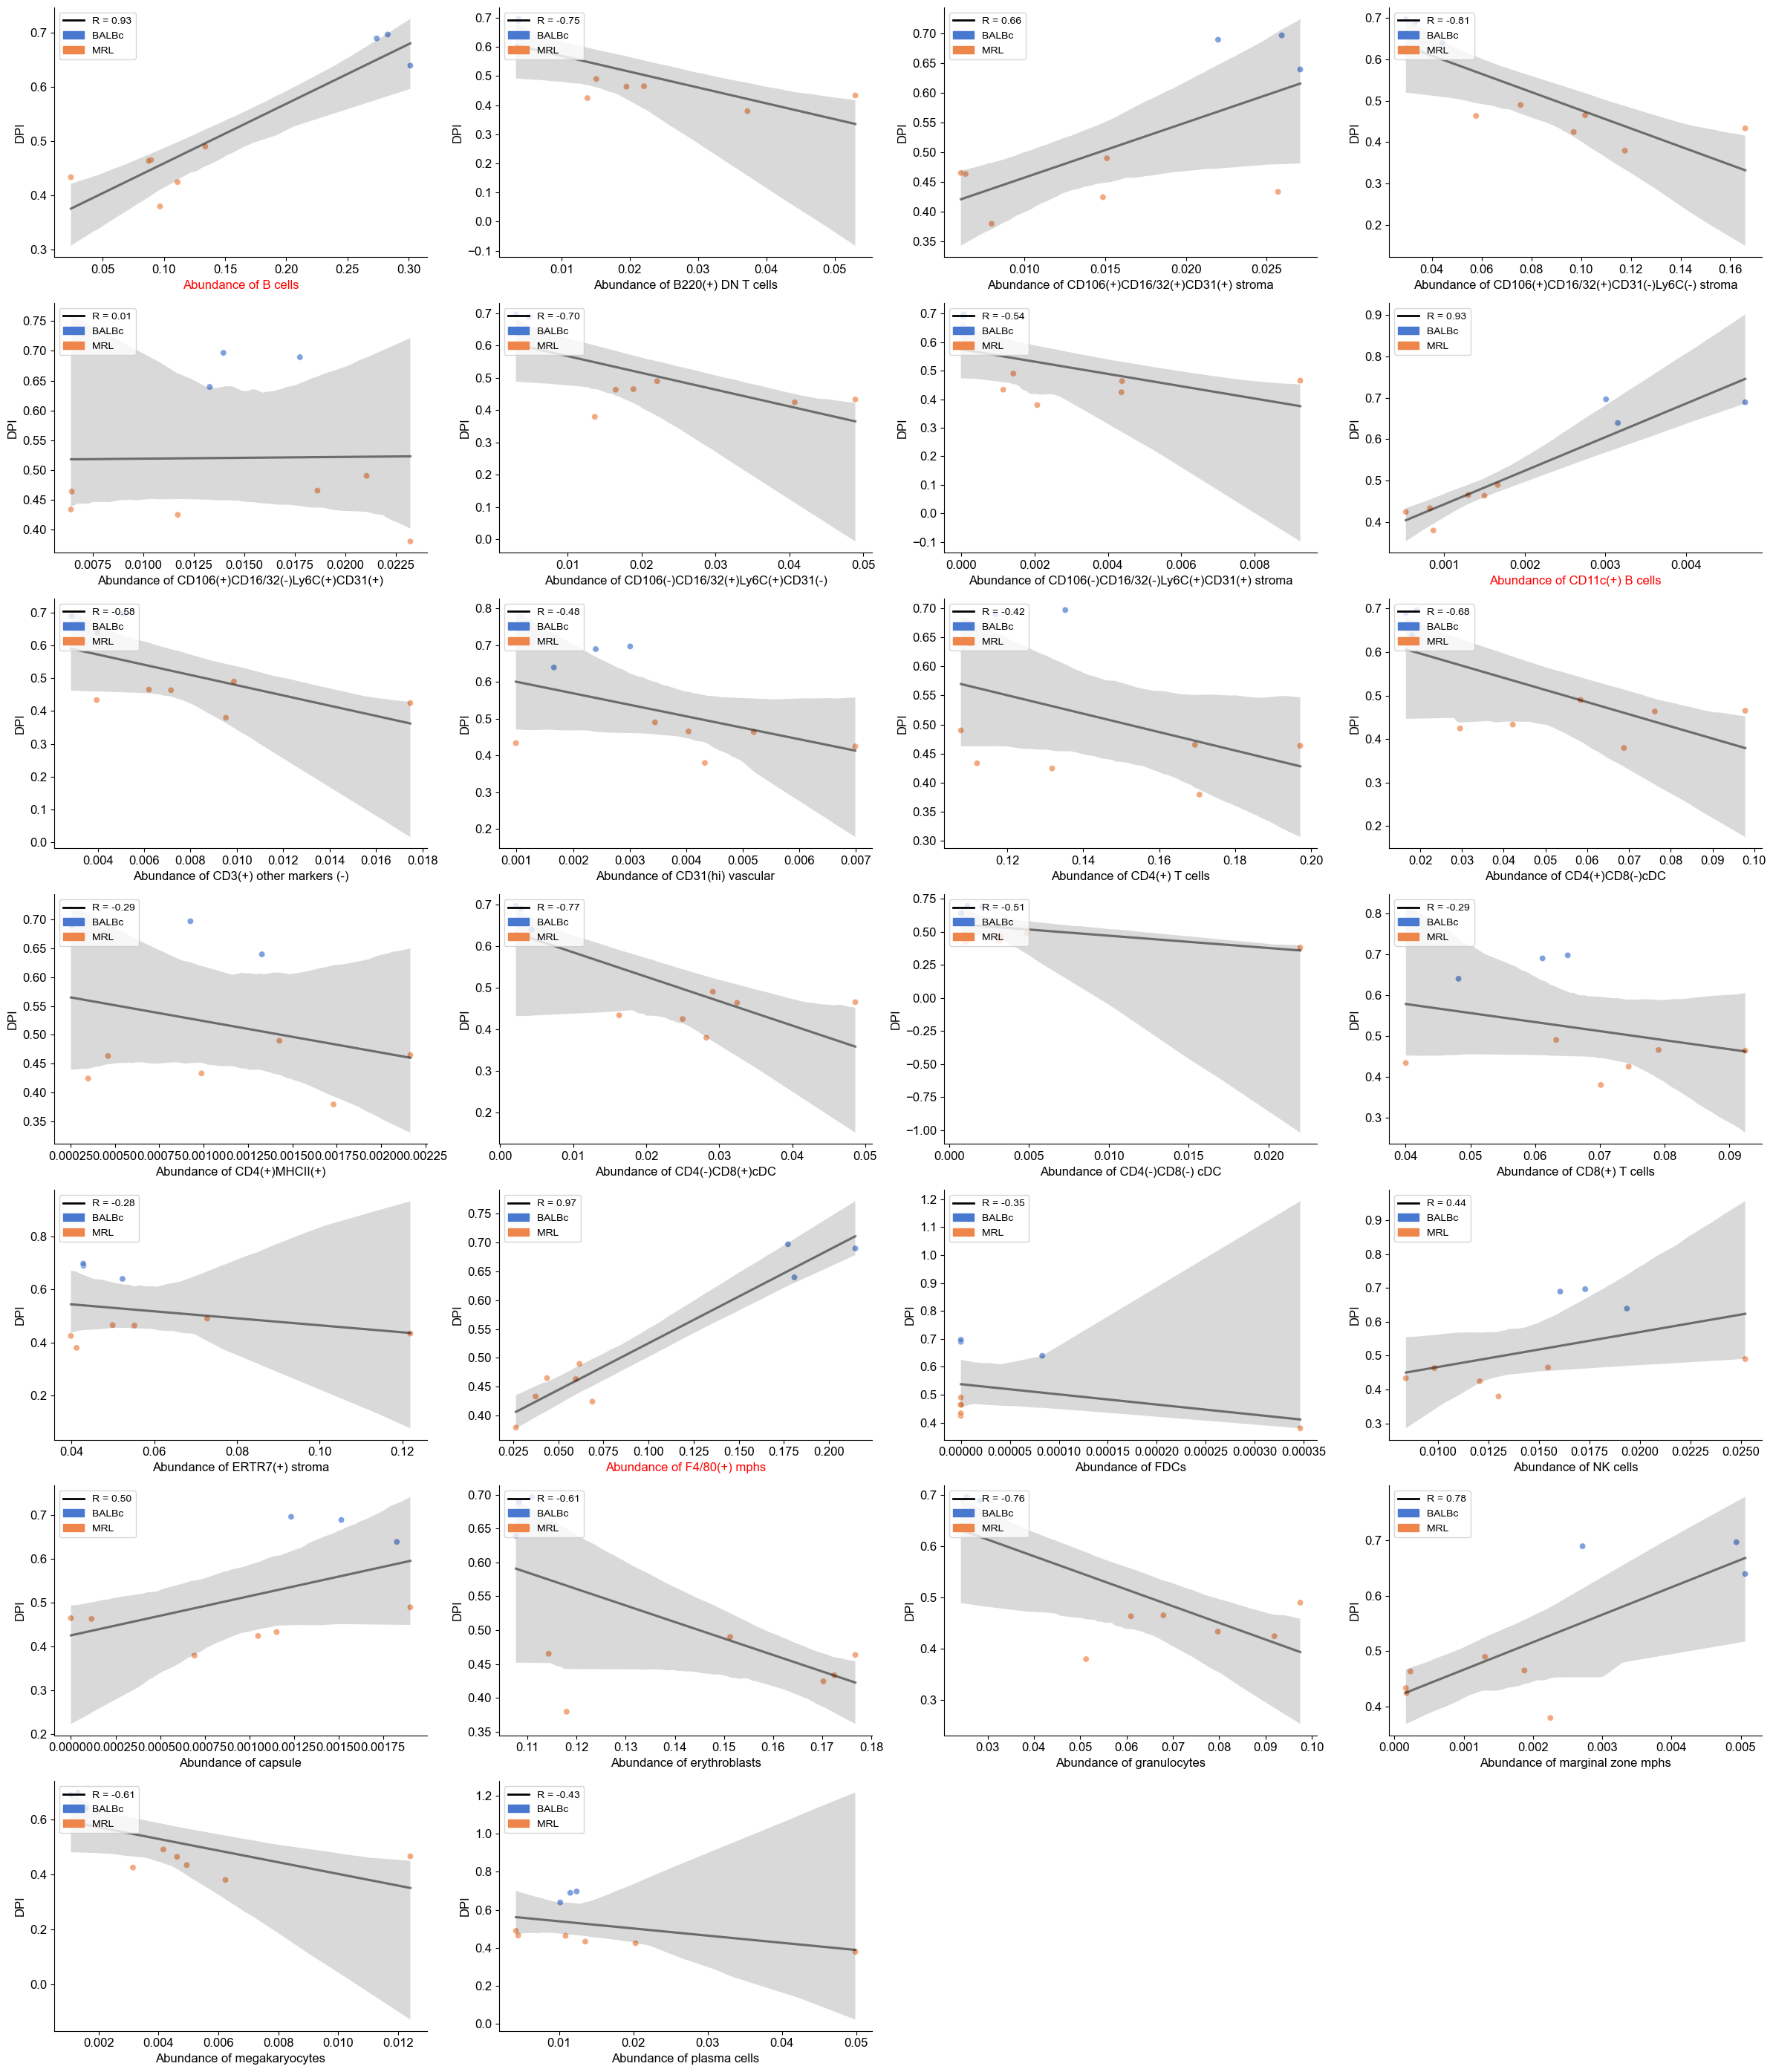

In [15]:
significant_species = [species for species, corr in pearson_correlations.items() if corr[1] < 0.05]
all_species = [species for species, corr in pearson_correlations.items()]

# Calculate the number of rows and columns for the subplots
n_species = len(all_species)
n_cols = 4  # You can adjust this number based on your preference
n_rows = (n_species + n_cols - 1) // n_cols  # Rounds up to ensure all plots fit

plt.figure(figsize=(n_cols * 6, n_rows * 4))  # Adjust the figure size as needed

for i, species in enumerate(all_species):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Data for plotting
    x = df_abundance[species]
    y = index_list
    hue = df_abundance['Condition']
    
    # Plot data points
    diverging_colors = sns.color_palette("muted", 10)
    extreme_colors = [diverging_colors[0], diverging_colors[1]]
    sns.scatterplot(x=x, y=y, hue=hue, palette=extreme_colors, ax=ax, alpha=0.7)

    # Fit and plot linear regression line with a confidence band
    sns.regplot(x=x, y=y, ci=95, scatter=False, line_kws={'color': 'black', 'alpha':0.5}, ax=ax)
    
    # Get the correlation coefficient
    corr_coef = pearson_correlations[species][0]
    
    sns.despine()
    xlabel_color = 'red' if species in significant_species else 'black'
    ax.set_xlabel(f'Abundance of {species}', fontsize=12, color=xlabel_color)
    ax.set_ylabel('DPI', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Custom legend
    legend_elements = [Line2D([0], [0], color='black', lw=2, label=f'R = {corr_coef:.2f}')]
    unique_conditions = df_abundance['Condition'].unique()
    for color, condition in zip(extreme_colors, unique_conditions):
        legend_elements.append(mpatches.Circle((0, 0), 0.1, facecolor=color, edgecolor=color, label=condition))

    ax.legend(handles=legend_elements, loc='upper left', handler_map={mpatches.Circle: HandlerPatch()})

plt.tight_layout()  # Adjusts the plots to fit into the figure area.
plt.savefig('../figures/mice/correlation_plots.svg')
plt.show()


In [13]:
# Melt the DataFrame
spot_freq = df_abundance.melt(id_vars=['Mouse', 'Condition'], var_name='CellType', value_name='Frequency')

In [14]:
spot_freq

Mouse Condition      CellType  Frequency
0    BALBc-1     BALBc       B cells   0.301445
1    BALBc-2     BALBc       B cells   0.273973
2    BALBc-3     BALBc       B cells   0.282948
3      MRL-4       MRL       B cells   0.133904
4      MRL-5       MRL       B cells   0.089479
..       ...       ...           ...        ...
238    MRL-5       MRL  plasma cells   0.004474
239    MRL-6       MRL  plasma cells   0.020276
240    MRL-7       MRL  plasma cells   0.010852
241    MRL-8       MRL  plasma cells   0.049887
242    MRL-9       MRL  plasma cells   0.013507

[243 rows x 4 columns]

p-value before correction:
B cells has p value = 0.0000
B220(+) DN T cells has p value = 0.0139
CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.0097
CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.0062
CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.9028
CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.0112
CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma has p value = 0.0295
CD11c(+) B cells has p value = 0.0342
CD3(+) other markers (-) has p value = 0.0460
CD31(hi) vascular has p value = 0.0861
CD4(+) T cells has p value = 0.1443
CD4(+)CD8(-)cDC has p value = 0.0067
CD4(+)MHCII(+) has p value = 0.4478
CD4(-)CD8(+)cDC has p value = 0.0015
CD4(-)CD8(-) cDC has p value = 0.1899
CD8(+) T cells has p value = 0.2234
ERTR7(+) stroma has p value = 0.2324
F4/80(+) mphs has p value = 0.0012
FDCs has p value = 0.6537
NK cells has p value = 0.2228
capsule has p value = 0.0739
erythroblasts has p value = 0.0149
granulocytes has p value = 0.0010
marginal zone mphs has p value = 0.0311
megakaryocy

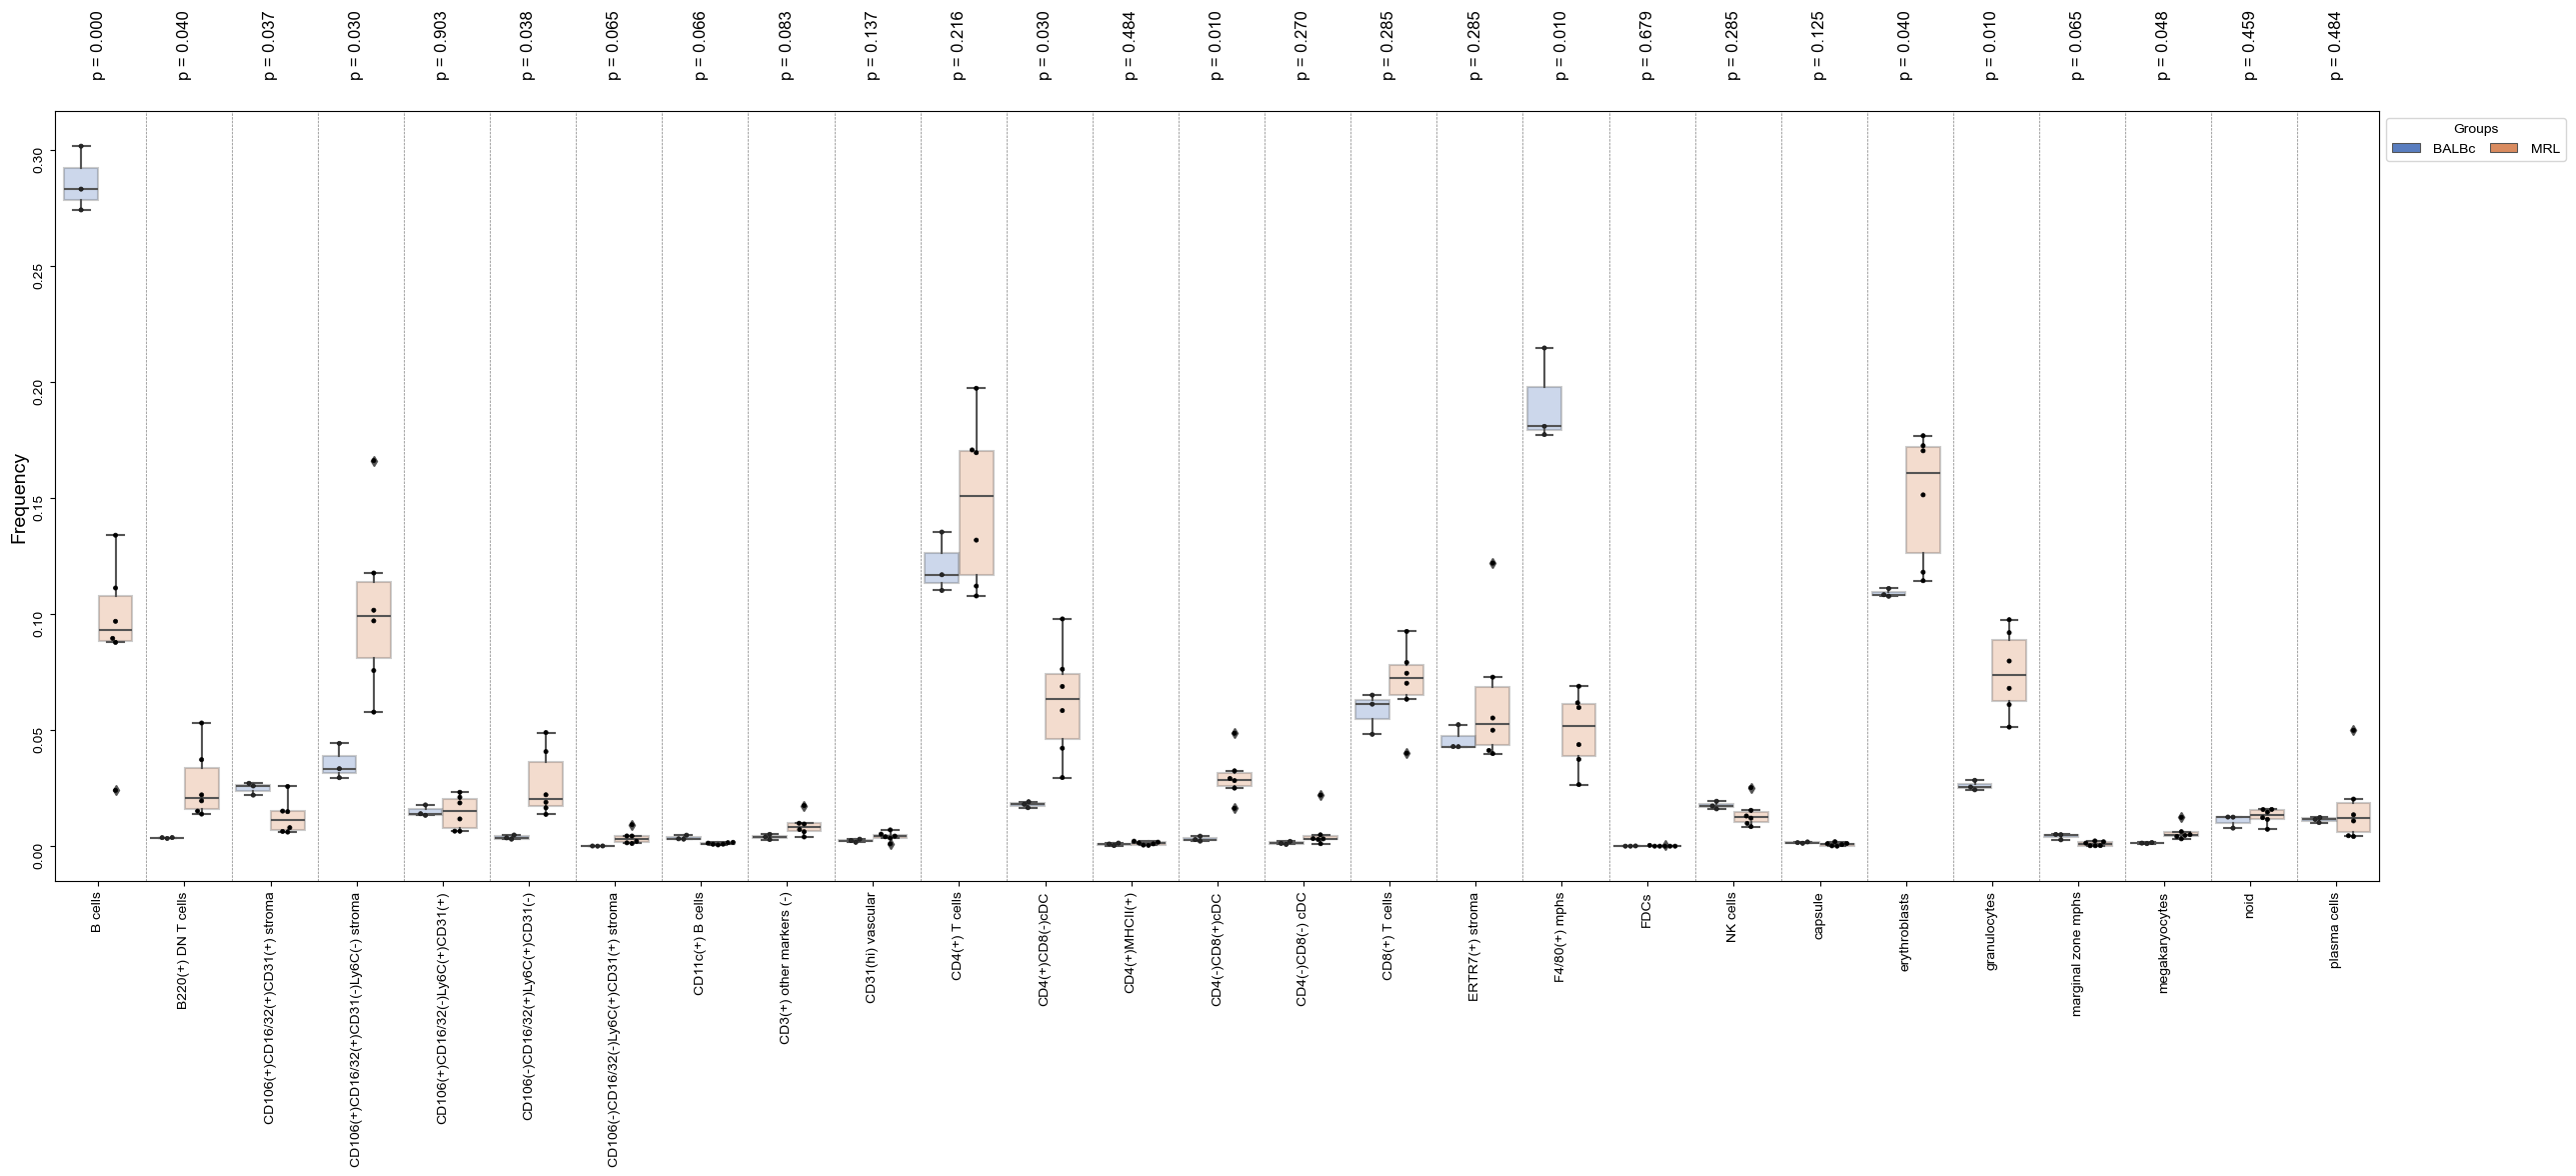

In [18]:
if Hot:
    save_path = 'hotspot_celltype_freq.svg'
else:
    save_path = 'coldspot_celltype_freq.svg'
    
selected_cell_types = sorted(spot_freq['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_freq[spot_freq['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.4f}")    
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_freq[spot_freq['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=3.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction: ")

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {hot_pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] > 0.05:
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')    
plt.xticks(rotation=90)  
plt.yticks(rotation=90) 
fig.savefig('../figures/mice/'+save_path)
plt.show()
plt.close(fig)


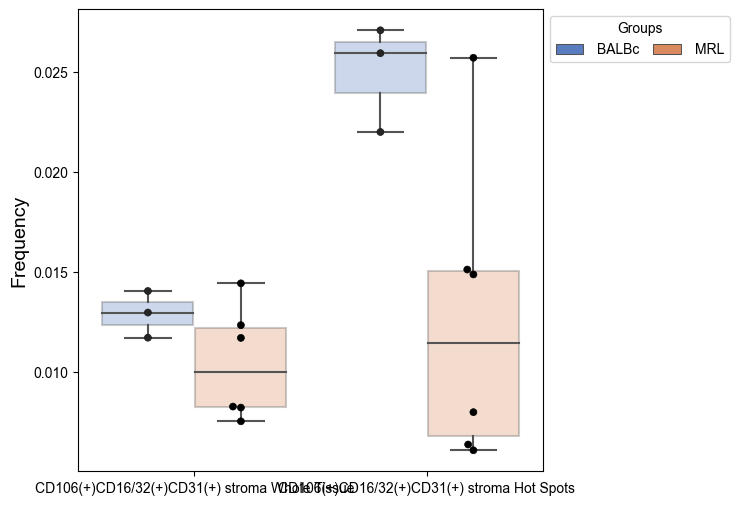

In [26]:
ct = 'CD106(+)CD16/32(+)CD31(+) stroma'
# Add a source column to each dataframe
grouped_melted['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Standardize the column names
df_melted.rename(columns={'CellType': 'cell_type', 'Condition': 'group'}, inplace=True)

# Combine the dataframes
combined_df = pd.concat([grouped_melted, df_melted], ignore_index=True)
combined_df['combined_x'] = combined_df['cell_type'] + ' ' + combined_df['source']

fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data=combined_df[combined_df['cell_type'] == ct], x='combined_x', y='Frequency', hue='group', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True)
sns.swarmplot(data=combined_df[combined_df['cell_type'] == ct], x='combined_x', y='Frequency', hue='group', palette='dark:black', size=5.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(set(combined_df['group']))], labels[:len(set(combined_df['group']))], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')

save_path = save_path = ct.replace(' ', '_').replace('/', '')+'.svg'
fig.savefig('../figures/mice/'+save_path)

## process and visualise cell co-occurence

In [16]:
spot_df1 = comb_freq_results_mice[0]
spot_df2 = comb_freq_results_mice[1]

# get the union of columns
columns = spot_df1.columns.union(spot_df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
spot_df1 = spot_df1.reindex(columns=columns).fillna(0)
spot_df2 = spot_df2.reindex(columns=columns).fillna(0)

336


In [17]:
temp = pd.concat([spot_df1, spot_df2],axis=0)
temp = temp.sort_index(axis=1) 
condition_col = temp['Condition']
temp = temp.drop(columns='Condition')

spot_comb_df = temp.loc[:, (temp[temp.columns.difference([('Condition','')])].mean() > 0.05)].copy()
spot_comb_df['Condition'] = condition_col
spot_comb_df['Mouse'] = spot_comb_df.index
spot_comb_df.sort_index(axis=1,inplace=True)

In [21]:
spot_comb_df = pd.concat([spot_df1, spot_df2],axis=0)
spot_comb_df['Mouse'] = spot_comb_df.index
spot_comb_df = spot_comb_df.reindex(columns=union_cols)
spot_comb_df = spot_comb_df.sort_index(axis=1)

In [24]:
spot_comb_df[('CD4(-)CD8(+)cDC','granulocytes')]

BALBc-1    0.011645
BALBc-2    0.014101
BALBc-3    0.000000
MRL-4      0.154167
MRL-5      0.171558
MRL-6      0.131902
MRL-7      0.098196
MRL-8      0.060423
MRL-9      0.089080
Name: (CD4(-)CD8(+)cDC, granulocytes), dtype: float64

In [51]:
count = calculate_interactions(spot_comb_df)
sorted_count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1],reverse=True)}
print(sorted_count)

{'F4/80(+) mphs': 24, 'B cells': 24, 'erythroblasts': 24, 'CD8(+) T cells': 24, 'ERTR7(+) stroma': 24, 'CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma': 24, 'CD4(+) T cells': 24, 'CD4(+)CD8(-)cDC': 22, 'CD106(+)CD16/32(-)Ly6C(+)CD31(+)': 21, 'granulocytes': 21, 'CD106(-)CD16/32(+)Ly6C(+)CD31(-)': 19, 'noid': 19, 'B220(+) DN T cells': 18, 'plasma cells': 18, 'CD4(-)CD8(+)cDC': 18, 'NK cells': 18, 'CD106(+)CD16/32(+)CD31(+) stroma': 17, 'CD3(+) other markers (-)': 17, 'CD4(-)CD8(-) cDC': 14, 'megakaryocytes': 13, 'CD31(hi) vascular': 11, 'CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma': 10, 'CD11c(+) B cells': 8, 'marginal zone mphs': 7, 'capsule': 4, 'CD4(+)MHCII(+)': 3, '': 2, 'Mouse': 1, 'Condition': 1}


In [22]:
# Multi-index to single-index column
new_columns = []
for col in spot_comb_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "Mouse" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)
spot_comb_df.columns = new_columns

spot_comb_df = spot_comb_df[[col for col in spot_comb_df.columns if 'noid' not in col]]

# Melt the DataFrame
df_melted = spot_comb_df.melt(id_vars=['Mouse', 'Condition'], var_name='CellType', value_name='Frequency')

p-value before correction: 
B cells&B220(+) DN T cells has p value = 0.004
B cells&CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.000
B cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.252
B cells&CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.008
B cells&CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.093
B cells&CD3(+) other markers (-) has p value = 0.390
B cells&CD4(+) T cells has p value = 0.006
B cells&CD4(+)CD8(-)cDC has p value = 0.408
B cells&CD4(-)CD8(+)cDC has p value = 0.007
B cells&CD8(+) T cells has p value = 0.016
B cells&ERTR7(+) stroma has p value = 0.027
B cells&F4/80(+) mphs has p value = 0.000
B cells&NK cells has p value = 0.010
B cells&erythroblasts has p value = 0.004
B cells&granulocytes has p value = 0.679
B cells&marginal zone mphs has p value = 0.024
B cells&plasma cells has p value = 0.314
B220(+) DN T cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.010
B220(+) DN T cells&CD4(+) T cells has p value = 0.002
B220(+) DN T cells&C

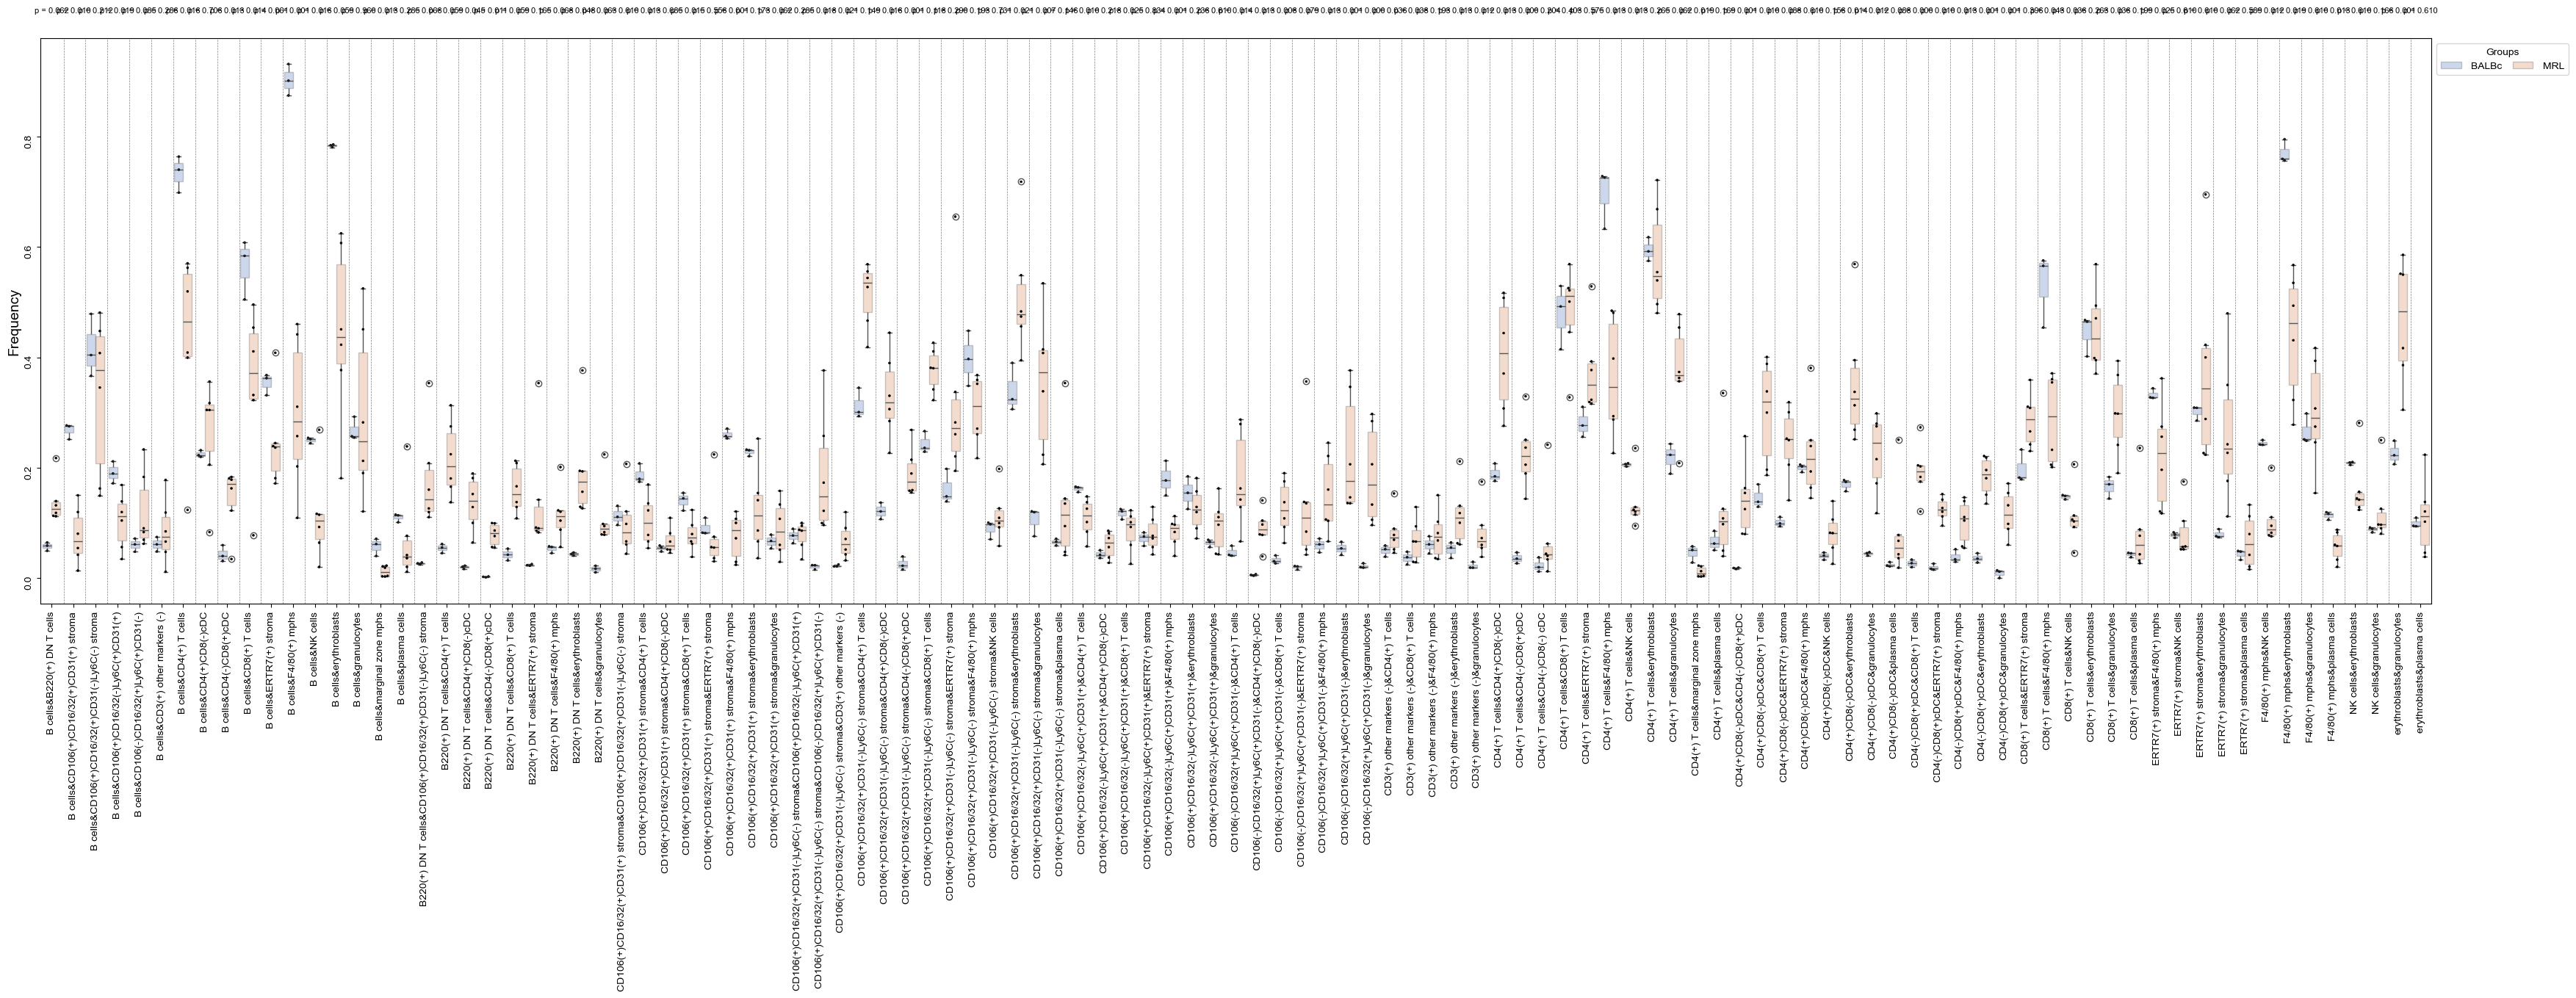

In [23]:
if Hot:
    save_path = 'hotspot_celltype_comb_freq.svg'
else:
    save_path = 'coldspot_celltype_comb_freq.svg'
    
selected_cell_types = sorted(df_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = df_melted[df_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = df_melted[df_melted['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(42,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

highlighted_comb = []
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] >= 0.05:
        highlighted_comb.append(tuple(map(str.strip, ct.split('&'))))
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
plt.yticks(rotation=90)  
# fig.savefig('../figures/mice/'+save_path)
plt.show()
plt.close(fig)


### circle plot

In [31]:
circoplot_df1 = spot_comb_df.drop(columns=['Mouse'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'noid' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

B cells                                   \
          B220(+) DN T cells CD106(+)CD16/32(+)CD31(+) stroma   
Condition                                                       
BALBc               0.057617                         0.267754   
MRL                 0.138697                         0.076683   

                                                   \
          CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma   
Condition                                           
BALBc                                    0.416566   
MRL                                      0.332347   

                                                                             \
          CD106(+)CD16/32(-)Ly6C(+)CD31(+) CD106(-)CD16/32(+)Ly6C(+)CD31(-)   
Condition                                                                     
BALBc                             0.190961                         0.060190   
MRL                               0.103709                         0.120283   

                                                                   \
          CD3(+) other markers (-) CD4(+) T cells CD4(+)CD8(-)cDC   
Condition                                                           
BALBc                     0.061251       0.734347        0.224730   
MRL                       0.084381       0.430770        0.261946   

                                          ... ERTR7(+) stroma               \
          CD4(-)CD8(+)cDC CD8(+) T cells  ...    granulocytes plasma cells   
Condition                                 ...                                
BALBc            0.043511       0.565753  ...        0.079555     0.043365   
MRL              0.143579       0.348793  ...        0.264536     0.067245   

          F4/80(+) mphs                                              NK cells  \
               NK cells erythroblasts granulocytes plasma cells erythroblasts   
Condition                                                                       
BALBc          0.244668      0.770760     0.266262     0.113863      0.208335   
MRL            0.106753      0.438014     0.298846     0.057091      0.162662   

                       erythroblasts               
          granulocytes  granulocytes plasma cells  
Condition                                          
BALBc         0.087958      0.226096     0.099391  
MRL           0.123358      0.465931     0.111451  

[2 rows x 109 columns]

In [32]:
circoplot_df2 = df_abundance.drop(columns=['Mouse'])
circoplot_df2 = circoplot_df2[[col for col in circoplot_df2.columns if 'noid' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

B cells  B220(+) DN T cells  CD106(+)CD16/32(+)CD31(+) stroma  \
Condition                                                                   
BALBc      0.286122            0.003563                          0.024994   
MRL        0.090528            0.026797                          0.012673   

           CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  \
Condition                                            
BALBc                                     0.035697   
MRL                                       0.102604   

           CD106(+)CD16/32(-)Ly6C(+)CD31(+)  CD106(-)CD16/32(+)Ly6C(+)CD31(-)  \
Condition                                                                       
BALBc                              0.015001                          0.003794   
MRL                                0.014580                          0.026811   

           CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma  CD11c(+) B cells  \
Condition                                                              
BALBc                                     0.000047          0.003634   
MRL                                       0.003775          0.001113   

           CD3(+) other markers (-)  CD31(hi) vascular  ...  ERTR7(+) stroma  \
Condition                                               ...                    
BALBc                      0.003974           0.002357  ...         0.046011   
MRL                        0.009032           0.004166  ...         0.063478   

           F4/80(+) mphs      FDCs  NK cells   capsule  erythroblasts  \
Condition                                                               
BALBc            0.19085  0.000028  0.017559  0.001526       0.108952   
MRL              0.04965  0.000058  0.013987  0.000819       0.150498   

           granulocytes  marginal zone mphs  megakaryocytes  plasma cells  
Condition                                                                  
BALBc          0.026025            0.004240        0.001321      0.011325  
MRL            0.074897            0.001001        0.005919      0.017193  

[2 rows x 26 columns]

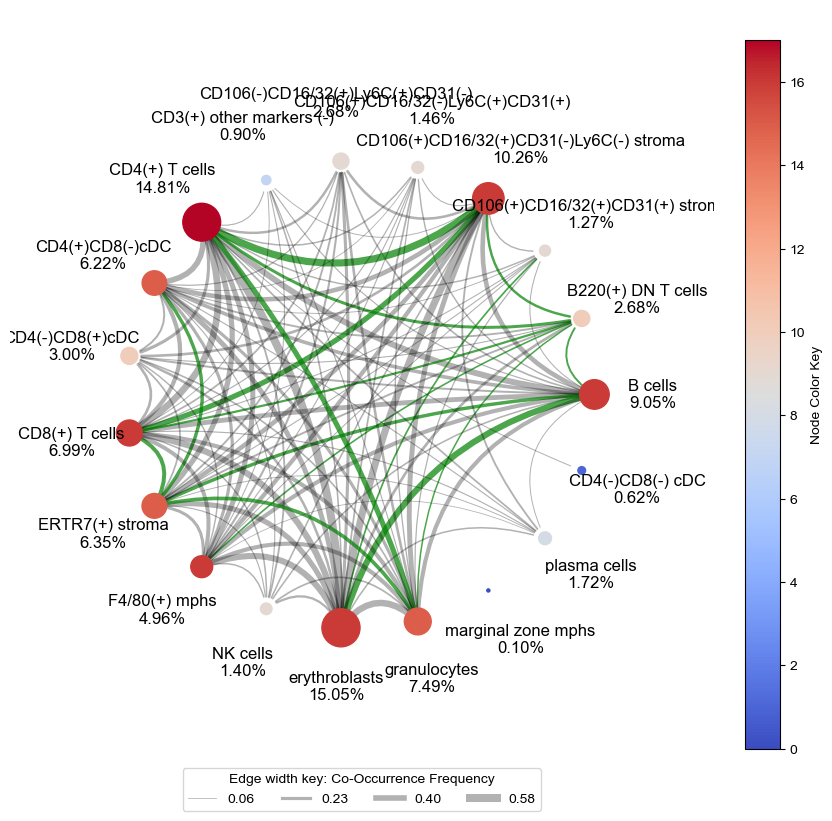

In [39]:
patient_group = 'MRL'
cirplot_save_path = '../figures/mice/hotspots_circleplot_'+ patient_group +'.svg'

msd.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path=cirplot_save_path)

### box plot

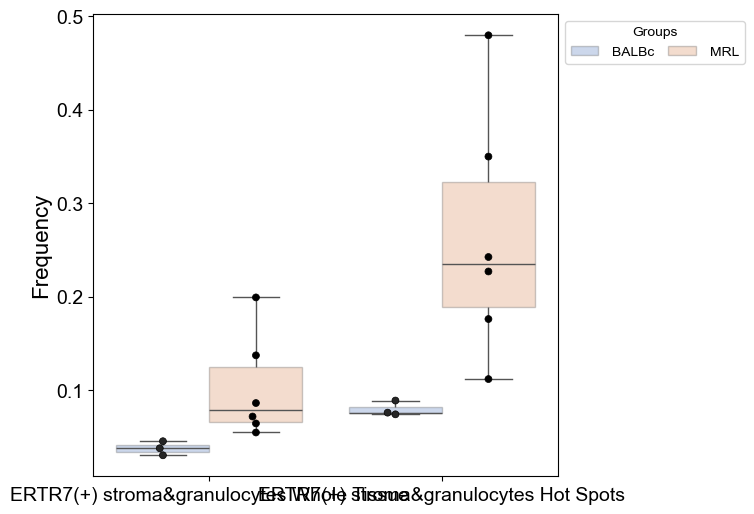

In [41]:
ct = 'ERTR7(+) stroma&granulocytes'
# Add a source column to each dataframe
grouped_melted['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Standardize the column names
# df_melted.rename(columns={'CellType': 'cell_type', 'Condition': 'group'}, inplace=True)

# Combine the dataframes
combined_df = pd.concat([grouped_melted, df_melted], ignore_index=True)
combined_df['combined_x'] = combined_df['CellType'] + ' ' + combined_df['source']

fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data=combined_df[combined_df['CellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True)
sns.swarmplot(data=combined_df[combined_df['CellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='dark:black', size=5.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(set(combined_df['Condition']))], labels[:len(set(combined_df['Condition']))], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_xlabel('')

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

save_path = save_path = ct.replace(' ', '_').replace('/', '')+'.svg'
fig.savefig('../figures/mice/'+save_path)

## hot spot:whole tissue fold of change

In [23]:
# Add a source column to each dataframe
grouped_melted['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Combine the dataframes
combined_df = pd.concat([grouped_melted, df_melted], ignore_index=True)

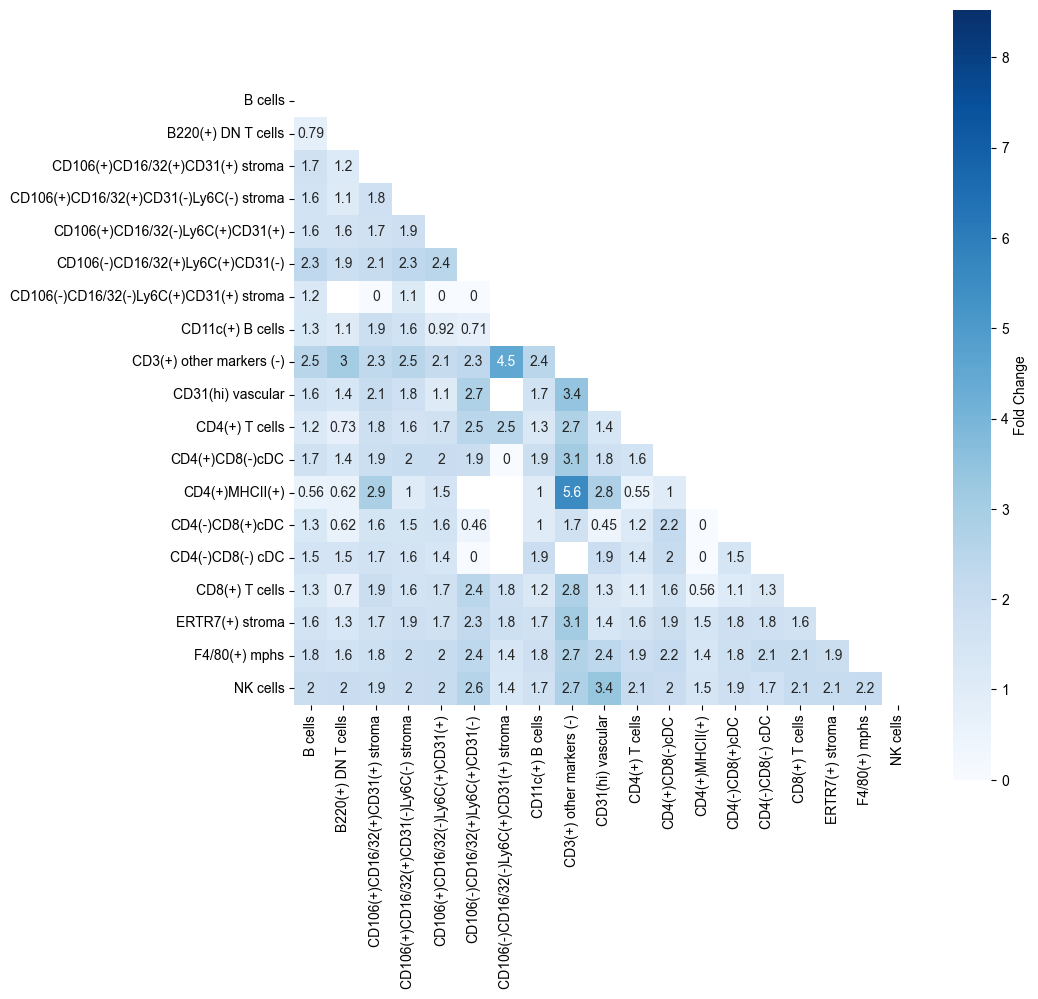

In [28]:
fold_changes = {}
patient_group = 'BALBc'
for combo in pairwise_combinations:
    cell_type_1, cell_type_2 = combo
    
    # Mean frequency for Whole Tissue
    whole_tissue_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['Condition'] == patient_group) &
                                    (combined_df['source'] == 'Whole Tissue')]['Frequency'].mean()
    
    # Mean frequency for Hot Spots
    hot_spots_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['Condition'] == patient_group) &
                                 (combined_df['source'] == 'Hot Spots')]['Frequency'].mean()
    
    # if ' '.join(combo) in remarkable_combinations:
    if whole_tissue_mean == 0 and hot_spots_mean != 0:
        fold_change = hot_spots_mean / (whole_tissue_mean + 1e-10)
    else:
        fold_change = hot_spots_mean / whole_tissue_mean
    fold_changes[(cell_type_1, cell_type_2)] = fold_change

# Convert fold_changes to a matrix for heatmap
heatmap_data = pd.DataFrame(index=selected_cell_combs, columns=selected_cell_combs)

for (cell_type_1, cell_type_2), fold_change in fold_changes.items():
    heatmap_data.at[cell_type_1, cell_type_2] = fold_change
    heatmap_data.at[cell_type_2, cell_type_1] = fold_change  # it's symmetric
    
sorted_values = sorted([value for value in np.unique(heatmap_data.values.ravel()) if not np.isnan(value)], reverse=True)

# Check the top value, and if it's infinite, select the second top value
for sorted_value in sorted_values:
    if sorted_value != np.inf:
        vmax_value = sorted_value
        break  # exit the loop once the value is found
vmax_value = 8.52777939407287

# Create a mask for the upper triangle.
mask = np.triu(np.ones_like(heatmap_data, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data.astype(float), mask=mask, annot=True, cmap='Blues', cbar_kws={'label': 'Fold Change'}, square=True, vmax=vmax_value, vmin=0)
plt.savefig("../figures/mice/fold_change_heatmap_"+patient_group+'.svg')
plt.savefig("../figures/mice/fold_change_heatmap_"+patient_group+'.png', dpi=300)
plt.show()

[8.169000168759114, 8.169000168759114, 7.086010988766006, 7.086010988766006, 5.189993233330436, 5.189993233330436, 4.3463334756492875, 4.3463334756492875, 4.058704980470661, 4.058704980470661, 3.875654675087458, 3.875654675087458, 3.6264037354571403, 3.6264037354571403, 3.164411070851956, 3.164411070851956, 3.1522370385226473, 3.1522370385226473, 3.076156432186602, 3.076156432186602, 2.98675767988348, 2.98675767988348, 2.9137342214745385, 2.7990541514173892, 2.7273164566101573, 2.7273164566101573, 2.6922928045057013, 2.6922928045057013, 2.628163456798704, 2.628163456798704, 2.599015506715878, 2.2962482827391586, 2.246426990080802, 2.246426990080802, 2.2081307571419115, 2.061079199950195, 2.0347542339974676, 2.0347542339974676, 2.0112273209212783, 2.0112273209212783, 2.0018598210407887, 1.9516837746363975, 1.9290337295431135, 1.8873866206627776, 1.8392315755371675, 1.8088749103839523, 1.7732741891403099, 1.7107157213942408, 1.7107157213942408, 1.697159047887917, 1.697159047887917, 1.674

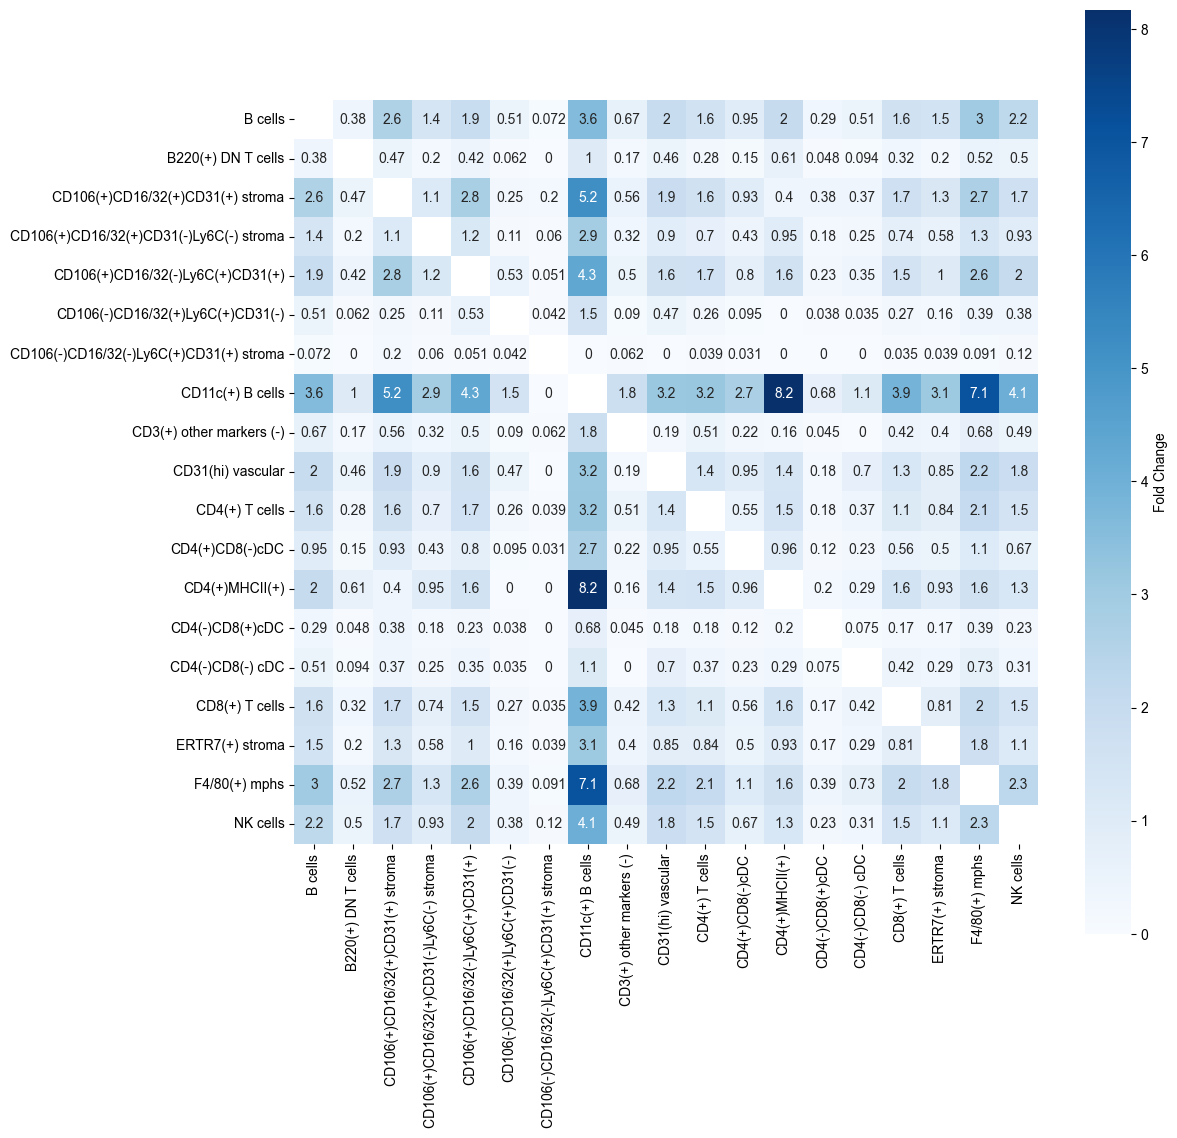

In [33]:
fold_changes = {}
region_group = 'Whole Tissue'
for combo in pairwise_combinations:
    cell_type_1, cell_type_2 = combo
    
    # Mean frequency for Whole Tissue
    CLR_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['source'] == region_group) &
                                    (combined_df['Condition'] == 'BALBc')]['Frequency'].mean()
    
    # Mean frequency for Hot Spots
    DII_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['source'] == region_group) &
                                 (combined_df['Condition'] == 'MRL')]['Frequency'].mean()
    # if ' '.join(combo) in remarkable_combinations:
    if DII_mean == 0 and CLR_mean != 0:
        fold_change = np.inf
    else:
        fold_change = CLR_mean / DII_mean
    fold_changes[(cell_type_1, cell_type_2)] = fold_change
    
# Convert fold_changes to a matrix for heatmap
heatmap_data = pd.DataFrame(index=selected_cell_combs, columns=selected_cell_combs)

for (cell_type_1, cell_type_2), fold_change in fold_changes.items():
    heatmap_data.at[cell_type_1, cell_type_2] = fold_change
    heatmap_data.at[cell_type_2, cell_type_1] = fold_change  # Because it's symmetric

sorted_values = sorted([value for value in np.unique(heatmap_data.values.ravel()) if not np.isnan(value)], reverse=True)
print(sorted_values)

# Check the top value, and if it's infinite, select the second top value
for sorted_value in sorted_values:
    if sorted_value != np.inf:
        vmax_value = sorted_value
        break  # exit the loop once the value is found
        
print(f"vmax values is {vmax_value}")
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data.astype(float), annot=True, cmap='Blues', cbar_kws={'label': 'Fold Change'}, square=True, vmax=vmax_value)
plt.savefig("../figures/mice/fold_change_heatmap_"+region_group+'.svg')
plt.savefig("../figures/mice/fold_change_heatmap_"+region_group+'.jpeg')
plt.show()